# Puerto Rico - Data Offerings Magazine

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import geopandas as gdp
import requests
import json
import re
import time
import warnings

warnings.filterwarnings('ignore')

## Economic Census

The Economic Census provides reliable business statistics that serve as the cornerstone for measuring U.S. businesses and their economic impact. These data, collected every five years on years ending in “2” and “7”, provides information that serve as the cornerstone for measuring U.S. businesses and their economic impact.  
  
This section is organized by cycle moving backward in time (2017, 2012, 2007, and 2002). Each subsection gathers data for Puerto Rico first followed by four states for comparison.  
  
  
Some summary statistics are pulled in line with data, but the visualizations are called at the end of this section.  
  
  
Note, there are irregularities and shifts in standardizations across the time periods resulting in messy merges and shifts. Inline comments and docstrings provide more context where specific calls are made.   

##### Other Important Notes on the Economic Census Data  
For Puerto Rico:  
- The 2002 Economic Census does not include a callable endpoint for Island Areas. So, we must gather information from the FTP.
- Before 2017, Manufacturing was presented seperate from all other sectors in summary tables for Puerto Rico.
  
For the rest of the United States:
- OPTAX is required to call the API. 
- In 2007 and 2002, OPTAX is listed differently from healthcare. The summary row is "A" rather than "99".

Other key Links for Puerto Rico:
- 2007 Manufacturing Economic Census Stats: https://www.census.gov/data/tables/2007/econ/census/puerto-rico.html
- 2012 Manufacturing Economic Census Stats: https://www.census.gov/data/tables/2012/econ/census/puerto-rico.html

### 2017 Econ Census

In [2]:
def get_pr_2017_econ_census():
    # call the Census API for Economic Census 2017 // Island Areas
    econ_2017_api ='https://api.census.gov/data/2017/ecn/islandareas?get=NAME,GEO_ID,NAICS2017_LABEL,NAICS2017,ESTAB,EMP,FIRM,PAYANN,RCPTOT,YEAR,SECTOR&for=state:72&key=fe43695217081ac28642ce11f71882d406075d04'
    
    # transform the request to json
    econ_2017_r = requests.get(econ_2017_api)
    econ_2017_j = econ_2017_r.json()
    
    # transform json into a dataframe
    econ_2017_df = pd.DataFrame(econ_2017_j[1:],columns=econ_2017_j[0])
    
    # all data from the API are "objects" so transform the necessary columns to numbers
    numeric_columns = ['ESTAB','EMP','FIRM','PAYANN','RCPTOT','YEAR','SECTOR']
    for column in numeric_columns:
        econ_2017_df[column] = econ_2017_df[column].astype(int)
    
    # retain only the NAICS codes that are two digits; these represent summary rows for the entire sector
    # and retain the pre-grouped summary rows which contain a dash 
    # and the summary of all workers
    econ_2017_df_grouped = econ_2017_df[(econ_2017_df['NAICS2017'].astype(str).str.len() == 2) | (econ_2017_df['NAICS2017'].str.contains('-')) | (econ_2017_df['SECTOR'] == 0)]
    
    # return the sorted data
    return econ_2017_df_grouped.sort_values(by='EMP',ascending=False)

In [4]:
# storing the variable for later use
econ_2017_df_grouped = get_pr_2017_econ_census()

In [5]:
# save the seven largest industries by revenue, sales, shipments, etc. 
pr_top_seven = econ_2017_df_grouped.sort_values(by='RCPTOT',ascending=False).head(7)
# drop the 'total for all sectors row'
pr_top_seven = pr_top_seven.drop(pr_top_seven[pr_top_seven['SECTOR'] == 0].index)

In [6]:
# isolate only manufacutring and retail for comparison
manuf_2017_rcptot = pr_top_seven['RCPTOT'].iloc[0]
retail_2017_rcptot = pr_top_seven['RCPTOT'].iloc[1]

# print the difference
manuf_difference_rcptot = (manuf_2017_rcptot / retail_2017_rcptot)

print('The total value generated by Manufacturing is', manuf_difference_rcptot, 'times the size of Retail trade.')
print('Retail:', retail_2017_rcptot)
print('Manufacturing:', manuf_2017_rcptot)

The total value generated by Manufacturing is 3.3494133935213077 times the size of Retail trade.
Retail: 25456248
Manufacturing: 85263498


Text(0.5, 1.0, 'Top Seven Industries by Value of Sales, Shipments, Receipts, Revenue, or Business Done (2017)')

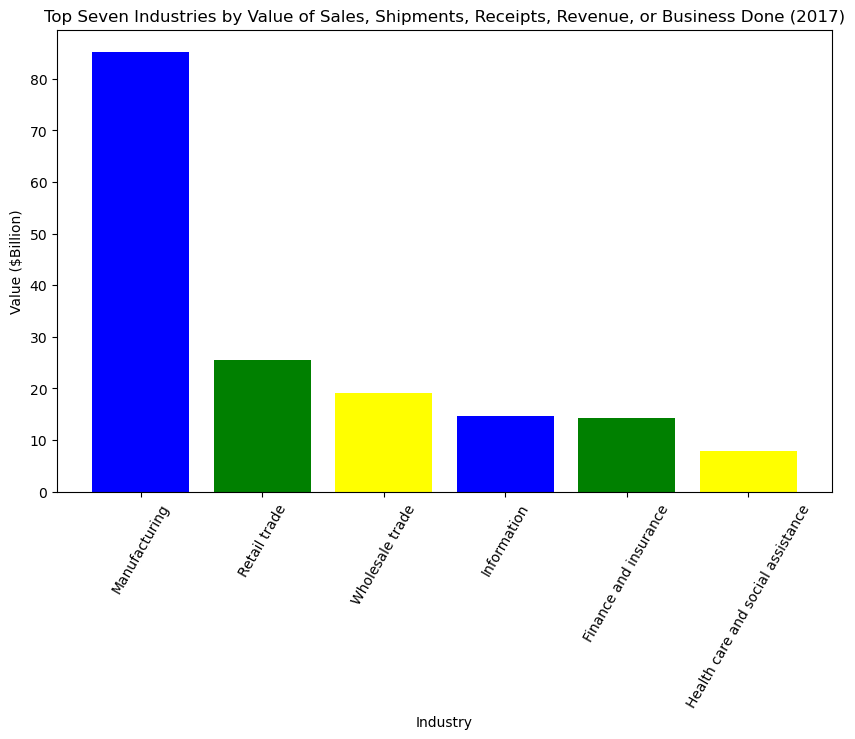

In [7]:
# scale revenue by a million (it was already scaled by 1,000) for readibility
scaled_revenue = pr_top_seven['RCPTOT'] / 1000000

# plotting the seven largested 
plt.figure(figsize=(10,6))
plt.bar(pr_top_seven['NAICS2017_LABEL'], scaled_revenue, color=['blue', 'green', 'yellow'])
plt.xlabel('Industry')
plt.ylabel('Value ($Billion)') 
plt.xticks(rotation=60)
plt.title('Top Seven Industries by Value of Sales, Shipments, Receipts, Revenue, or Business Done (2017)')

In [8]:
#pr_top_seven.to_csv('seven_largest_industries_by_RCPTOT_2017.csv', index=False)

##### Puerto Rico and Comparable Mainland States

In [9]:
# set up a dictionary of state FIPS codes
state_fips_dict = {
    'MS':'28', # Mississippi
    'NM':'35', # New Mexico
    'IA':'19', # Iowa
    'NV':'32' # Nevada
}

In [10]:
# creating a general function to call econ census data for 2017 for multiple states

def get_state_2017_econ_census(state_abbrev):
    # call the Census API for Economic Census 2017 
    econ_2017_api_base ='https://api.census.gov/data/2017/ecnbasic?get=NAME,GEO_ID,NAICS2017_LABEL,NAICS2017,ESTAB,EMP,FIRM,PAYANN,RCPTOT,YEAR,SECTOR&for=state:'
    
    # add the state FIPS based on function argument
    state_code = state_fips_dict[state_abbrev]
    key = '&key=fe43695217081ac28642ce11f71882d406075d04'
    
    # concatenate url 
    econ_2017_api = econ_2017_api_base + state_code + key
    
    # transform the request to json
    econ_2017_r = requests.get(econ_2017_api)
    econ_2017_j = econ_2017_r.json()

    # transform json into a dataframe
    econ_2017_df = pd.DataFrame(econ_2017_j[1:],columns=econ_2017_j[0])

    # all data from the API are "objects" so transform the necessary columns to numbers
    numeric_columns = ['ESTAB','EMP','FIRM','PAYANN','RCPTOT','YEAR','SECTOR']
    for column in numeric_columns:
        econ_2017_df[column] = econ_2017_df[column].astype(int)

    # retain only the NAICS codes that are two digits; these represent summary rows for the entire sector
    # and retain the pre-grouped summary rows which contain a dash 
    econ_2017_df_grouped = econ_2017_df[(econ_2017_df['NAICS2017'].astype(str).str.len() == 2) | (econ_2017_df['NAICS2017'].str.contains('-'))]

    #creating a summary row
    columns_to_sum = ['ESTAB','EMP','FIRM','PAYANN','RCPTOT']
    summary_values = econ_2017_df_grouped[columns_to_sum].sum()
    new_row = econ_2017_df_grouped.iloc[0].to_dict()
    
    #set the values for the summary
    new_row['NAICS2017_LABEL'] = 'Total for all sectors'
    new_row['NAICS2017'] = '00'
    new_row['SECTOR'] = 0
    
    #append the summary row to the dataframe
    for column in columns_to_sum:
        new_row[column] = summary_values[column]
    econ_2017_df_grouped_w_sum = econ_2017_df_grouped.append(new_row, ignore_index=True)

    # return the sorted data
    return econ_2017_df_grouped_w_sum.sort_values(by='EMP',ascending=False)    

In [11]:
# storing the results of each state in a variable for later analysis
econ_2017_mississippi = get_state_2017_econ_census('MS')
econ_2017_new_mexico = get_state_2017_econ_census('NM')
econ_2017_iowa = get_state_2017_econ_census('IA')
econ_2017_nevada = get_state_2017_econ_census('NV')

##### Comparing the U.S. and Puerto Rico 

In [12]:
# pull the total number of workers and the total numbers for each industry.

def find_pr_worker_stats():
    # call the Census API for Economic Census 2017 // Island Areas
    econ_2017_api ='https://api.census.gov/data/2017/ecn/islandareas?get=NAME,GEO_ID,NAICS2017_LABEL,NAICS2017,ESTAB,EMP,FIRM,PAYANN,RCPTOT,YEAR,SECTOR&for=state:72&key=fe43695217081ac28642ce11f71882d406075d04'

    # transform the request to json
    econ_2017_r = requests.get(econ_2017_api)
    econ_2017_j = econ_2017_r.json()

    # transform json into a dataframe
    econ_2017_df = pd.DataFrame(econ_2017_j[1:],columns=econ_2017_j[0])

    # all data from the API are "objects" so transform the necessary columns to numbers
    numeric_columns = ['ESTAB','EMP','FIRM','PAYANN','RCPTOT','YEAR','SECTOR']
    for column in numeric_columns:
        econ_2017_df[column] = econ_2017_df[column].astype(int)

    # isolate the values for simple math
    total_puerto_rican_workers = econ_2017_df[econ_2017_df['SECTOR'] == 0]['EMP'].values[0]
    puerto_rican_workers_retail = econ_2017_df[econ_2017_df['NAICS2017_LABEL'] == 'Retail trade']['EMP'].values[0]
    puerto_rican_workers_manufacturing = econ_2017_df[econ_2017_df['NAICS2017_LABEL'] == 'Manufacturing']['EMP'].values[0]

    # find the proportion of workers in each sector 
    percent_retail = round((puerto_rican_workers_retail/total_puerto_rican_workers) * 100, 2)
    percent_manufacturing = round((puerto_rican_workers_manufacturing/total_puerto_rican_workers) * 100, 2)
    
    print(percent_retail, '% of Puerto Rican workers are employed in the retail sector;', percent_manufacturing, '% of Puerto Rican workers are employed in the manufacutring sector.')

In [13]:
find_pr_worker_stats()

20.26 % of Puerto Rican workers are employed in the retail sector; 11.82 % of Puerto Rican workers are employed in the manufacutring sector.


In [14]:
# pull the total number of workers and the total numbers for each industry.

def find_us_wokers_stats():
    us_econ_2017_api ='https://api.census.gov/data/2017/ecnbasic?get=NAICS2017_LABEL,NAICS2017,YEAR,SECTOR,GEO_ID,EMP,RCPTOT,PAYANN&for=us:1&key=fe43695217081ac28642ce11f71882d406075d04'

    us_econ_2017_r = requests.get(us_econ_2017_api)
    us_econ_2017_j = us_econ_2017_r.json()

    us_econ_2017_df = pd.DataFrame(us_econ_2017_j[1:],columns=us_econ_2017_j[0])

    # clean the dataset 
    numeric_columns = ['EMP','RCPTOT','PAYANN','YEAR','SECTOR']
    for column in numeric_columns:
        us_econ_2017_df[column] = us_econ_2017_df[column].astype(float)

    us_econ_2017_df_grouped = us_econ_2017_df[(us_econ_2017_df['NAICS2017'].astype(str).str.len() == 2) | (us_econ_2017_df['NAICS2017'].str.contains('-'))]

    total_us_workers = us_econ_2017_df_grouped['EMP'].sum()
    
    # find the proportion of workers in each industry 

    us_workers_retail = us_econ_2017_df_grouped[us_econ_2017_df_grouped['NAICS2017_LABEL'] == 'Retail trade']['EMP'].values[0]
    us_workers_manufacturing = us_econ_2017_df_grouped[us_econ_2017_df_grouped['NAICS2017_LABEL'] == 'Manufacturing']['EMP'].values[0]
    us_percent_retail = round((us_workers_retail/total_us_workers) * 100, 2)
    us_percent_manufacturing = round((us_workers_manufacturing/total_us_workers) * 100, 2)

    print(us_percent_retail, '% of the U.S. workers are employed in the retail sector;', us_percent_manufacturing, '% of the U.S. workers are employed in the manufacutring sector.')

In [15]:
find_us_wokers_stats()

12.79 % of the U.S. workers are employed in the retail sector; 9.25 % of the U.S. workers are employed in the manufacutring sector.


#### 2012 Econ Census

In [16]:
def get_pr_2012_econ_census():
    # call the Census API for Economic Census 2012 // Island Areas
    econ_2012_api ='https://api.census.gov/data/2012/ecn/islandareas?get=NAME,GEO_ID,NAICS2012_LABEL,NAICS2012,ESTAB,EMP,FIRM,PAYANN,RCPTOT,YEAR,SECTOR&for=state:72&key=fe43695217081ac28642ce11f71882d406075d04'

    # save the json from the api request and save it as a dataframe 
    econ_2012_r = requests.get(econ_2012_api)
    econ_2012_j = econ_2012_r.json()
    econ_2012_df = pd.DataFrame(econ_2012_j[1:],columns=econ_2012_j[0])
    
    # all data from the API are "objects" so transform the necessary columns to numbers
    numeric_columns = ['ESTAB','EMP','FIRM','PAYANN','RCPTOT','YEAR','SECTOR']
    for column in numeric_columns:
        econ_2012_df[column] = econ_2012_df[column].astype(int)
    
    # retain only the NAICS codes that are two digits; these represent summary rows for the entire sector
    # and retain the pre-grouped summary rows which contain a dash 
    econ_2012_df_grouped = econ_2012_df[(econ_2012_df['NAICS2012'].astype(str).str.len() == 2) | (econ_2012_df['NAICS2012'].str.contains('-')) | (econ_2012_df['SECTOR'] == 0)]
    
    #creating a summary row
    columns_to_sum = ['ESTAB','EMP','FIRM','PAYANN','RCPTOT']
    summary_values = econ_2012_df_grouped[columns_to_sum].sum()
    new_row = econ_2012_df_grouped.iloc[0].to_dict()
    
    #set the values for the summary
    new_row['NAICS2012_LABEL'] = 'Total for all sectors'
    new_row['NAICS2012'] = '00'
    new_row['SECTOR'] = 0
    
    #append the summary row to the dataframe
    for column in columns_to_sum:
        new_row[column] = summary_values[column]
    econ_2012_df_grouped_w_sum = econ_2012_df_grouped.append(new_row, ignore_index=True)

    # return the cleaned the sorted data set 
    return econ_2012_df_grouped_w_sum.sort_values(by='EMP',ascending=False)
    

In [17]:
# storing the variable for later use
econ_2012_df_grouped =  get_pr_2012_econ_census()

In [56]:
econ_2012_df_grouped.sort_values(by='RCPTOT')

# note the utilities have zero values because the economic census captures private sector information NOT public sector information

NAME       GEO_ID  \
1   Puerto Rico  0400000US72   
2   Puerto Rico  0400000US72   
15  Puerto Rico  0400000US72   
8   Puerto Rico  0400000US72   
13  Puerto Rico  0400000US72   
10  Puerto Rico  0400000US72   
5   Puerto Rico  0400000US72   
4   Puerto Rico  0400000US72   
11  Puerto Rico  0400000US72   
12  Puerto Rico  0400000US72   
14  Puerto Rico  0400000US72   
9   Puerto Rico  0400000US72   
7   Puerto Rico  0400000US72   
6   Puerto Rico  0400000US72   
0   Puerto Rico  0400000US72   
3   Puerto Rico  0400000US72   
16  Puerto Rico  0400000US72   

                                      NAICS2012_LABEL NAICS2012  ESTAB  \
1                                           Utilities        22     23   
2       Mining, quarrying, and oil and gas extraction        21     51   
15                Arts, entertainment, and recreation        71    341   
8                                Educational services        61    440   
13      Other services (except public administration)        81   2070   
10            Management of companies and enterprises        55     88   
5                  Real estate and rental and leasing        53   1592   
4                      Transportation and warehousing     48-49    918   
11  Administrative and support and waste managemen...        56   1644   
12   Professional, scientific, and technical services        54   4044   
14                    Accommodation and food services        72   4084   
9                   Health care and social assistance        62   7014   
7                                         Information        51    727   
6                               Finance and insurance        52   1791   
0                                     Wholesale trade        42   1988   
3                                        Retail trade     44-45   9732   
16                              Total for all sectors        00  36547   

       EMP   FIRM    PAYANN    RCPTOT  YEAR  SECTOR state  
1        0     23         0         0  2012      22    72  
2      701     48     14671     83874  2012      21    72  
15    3024    323     62745    187328  2012      71    72  
8     9809    409    160972    462482  2012      61    72  
13   16144   1881    224347    750512  2012      81    72  
10    3931     56    182603    835387  2012      55    72  
5    11310   1367    262402   1465763  2012      53    72  
4    13716    864    356088   1918575  2012      48    72  
11   85049   1539   1447914   2948546  2012      56    72  
12   49750   3898   1060800   3145282  2012      54    72  
14   74741   2888   1135032   4256139  2012      72    72  
9    80913   6580   1842086   6098340  2012      62    72  
7    22610    459    542569  12342587  2012      51    72  
6    30950    822   1172737  14644495  2012      52    72  
0    31462   1801   1120124  20184374  2012      42    72  
3   124887   5722   1995812  24957584  2012      44    72  
16  558997  28680  11580902  94281268  2012       0    72

In [19]:
# creating a general function to call econ census data for 2017 for multiple states

def get_state_2012_econ_census(state_abbrev):
    # call the Census API for Economic Census 2012
    econ_2012_api_base = 'https://api.census.gov/data/2012/ecnbasic?get=NAME,GEO_ID,NAICS2012_LABEL,NAICS2012,ESTAB,EMP,PAYANN,RCPTOT,YEAR,SECTOR&for=state:'
    state_code = state_fips_dict[state_abbrev]
    key = '&key=fe43695217081ac28642ce11f71882d406075d04'
    
    # concatenate url 
    econ_2012_api = econ_2012_api_base + state_code + key
    
    # transform the request to json
    econ_2012_r = requests.get(econ_2012_api)
    econ_2012_j = econ_2012_r.json()
    
    # transform json into a dataframe
    econ_2012_df = pd.DataFrame(econ_2012_j[1:],columns=econ_2012_j[0])
    
    # all data from the API are "objects" so transform the necessary columns to numbers
    numeric_columns = ['ESTAB','EMP','PAYANN','RCPTOT','YEAR','SECTOR']
    for column in numeric_columns:
        econ_2012_df[column] = econ_2012_df[column].astype(int)
    
    # retain only the NAICS codes that are two digits; these represent summary rows for the entire sector
    # and retain the pre-grouped summary rows which contain a dash 
    econ_2012_df_grouped = econ_2012_df[(econ_2012_df['NAICS2012'].astype(str).str.len() == 2) | (econ_2012_df['NAICS2012'].str.contains('-')) | (econ_2012_df['SECTOR'] == 0)]
    
    #creating a summary row
    columns_to_sum = ['ESTAB','EMP','PAYANN','RCPTOT']
    summary_values = econ_2012_df_grouped[columns_to_sum].sum()
    new_row = econ_2012_df_grouped.iloc[0].to_dict()
    
    #set the values for the summary
    new_row['NAICS2012_LABEL'] = 'Total for all sectors'
    new_row['NAICS2012'] = '00'
    new_row['SECTOR'] = 0
    
    #append the summary row to the dataframe
    for column in columns_to_sum:
        new_row[column] = summary_values[column]
    econ_2012_df_grouped_w_sum = econ_2012_df_grouped.append(new_row, ignore_index=True)
   
    # return the sorted data
    return econ_2012_df_grouped_w_sum.sort_values(by='EMP',ascending=False)    

In [20]:
# storing the results of each state in a variable for later analysis
econ_2012_mississippi = get_state_2012_econ_census('MS')
econ_2012_new_mexico = get_state_2012_econ_census('NM')
econ_2012_iowa = get_state_2012_econ_census('IA')
econ_2012_nevada = get_state_2012_econ_census('NV')

#### 2007 Econ Census

In [21]:
def get_pr_2007_econ_census():
    # Call the Census API for Economic Census 2007 // Island Areas
    econ_2007_api ='https://api.census.gov/data/2007/ewks?get=GEO_ID,NAICS2007,NAICS2007_MEANING,ESTAB,EMP,PAYANN,RCPTOT,YEAR,SECTOR,OPTAX&for=state:72&key=fe43695217081ac28642ce11f71882d406075d04'
    
    # make the request in json format and save it as a dataframe
    econ_2007_r = requests.get(econ_2007_api)
    econ_2007_j = econ_2007_r.json()
    econ_2007_df = pd.DataFrame(econ_2007_j[1:],columns=econ_2007_j[0])
    
    # all data from the API are "objects" so transform the necessary columns to numbers
    numeric_columns = ['ESTAB','EMP','PAYANN','RCPTOT','YEAR','SECTOR']
    for column in numeric_columns:
        econ_2007_df[column] = econ_2007_df[column].astype(int)
        
    # drop the row which contains a "total for all sectors"; it is alwasy labeled with a zero but can appear anywhere
    econ_2007_df = econ_2007_df.drop(econ_2007_df[econ_2007_df['SECTOR'] == 0].index)
    
    # retain only the NAICS codes that are two digits; these represent summary rows for the entire sector
    # and retain the pre-grouped summary rows which contain a dash 
    econ_2007_df_grouped = econ_2007_df[(econ_2007_df['NAICS2007'].astype(str).str.len() == 2) | (econ_2007_df['NAICS2007'].str.contains('-'))]

    #creating a summary row
    columns_to_sum = ['ESTAB','EMP','PAYANN','RCPTOT']
    summary_values = econ_2007_df_grouped[columns_to_sum].sum()
    new_row = econ_2007_df_grouped.iloc[0].to_dict()
    
    #set the values for the summary
    new_row['NAICS2007_MEANING'] = 'Total for all sectors'
    new_row['NAICS2007'] = '00'
    new_row['SECTOR'] = 0
    
    #append the summary row to the dataframe
    for column in columns_to_sum:
        new_row[column] = summary_values[column]
    econ_2007_df_grouped_w_sum = econ_2007_df_grouped.append(new_row, ignore_index=True)
   
    # return the sorted data
    return econ_2007_df_grouped_w_sum.sort_values(by='EMP',ascending=False)   

In [22]:
# storing the variable for later use
econ_2007_df_grouped = get_pr_2007_econ_census()

In [24]:
def get_state_2007_econ_census(state_abbrev):
    # call the Census API for Economic Census 2007
    econ_2007_api_base = 'https://api.census.gov/data/2007/ewks?get=GEO_ID,NAICS2007,NAICS2007_MEANING,EMP,ESTAB,PAYANN,RCPTOT,SECTOR,YEAR,OPTAX&for=state:'
    state_code = state_fips_dict[state_abbrev]
    key = '&key=fe43695217081ac28642ce11f71882d406075d04'
    
    # concatenate url 
    econ_2007_api = econ_2007_api_base + state_code + key
    
    # transform the request to json
    econ_2007_r = requests.get(econ_2007_api)
    econ_2007_j = econ_2007_r.json()
    
    # transform json into a dataframe
    econ_2007_df = pd.DataFrame(econ_2007_j[1:],columns=econ_2007_j[0])
    
    # all data from the API are "objects" so transform the necessary columns to numbers
    numeric_columns = ['ESTAB','EMP','PAYANN','RCPTOT','YEAR','SECTOR']
    for column in numeric_columns:
        econ_2007_df[column] = econ_2007_df[column].astype(int)
    
    # drop the row which contains a "total for all sectors"; it is alwasy labeled with a zero but can appear anywhere
    econ_2007_df_sectors = econ_2007_df.drop(econ_2007_df[econ_2007_df['SECTOR'] == 0].index)
    
    # retain only the NAICS codes that are two digits; these represent summary rows for the entire sector
    # and retain the pre-grouped summary rows which contain a dash 
    econ_2007_df_grouped = econ_2007_df_sectors[(econ_2007_df_sectors['NAICS2007'].astype(str).str.len() == 2) | (econ_2007_df_sectors['NAICS2007'].str.contains('-'))]
    
    #In 2007 and 2002, healthcare is not subject to a 'total row', so extract the "A" or all row to concatenate to the new table
    econ_2007_df_healthcare = econ_2007_df_grouped[econ_2007_df_grouped['OPTAX'].str.contains('A')]
    
    # and retain only "99" representing 'total' of operation or tax status codes. i.e. the summary row for all sectors
    econ_2007_df_grouped = econ_2007_df_grouped[econ_2007_df_grouped['OPTAX'].str.contains('99')]
    
    # re-merge the full list
    econ_2007_df_grouped = pd.concat([econ_2007_df_healthcare,econ_2007_df_grouped])
    
    #creating a summary row
    columns_to_sum = ['ESTAB','EMP','PAYANN','RCPTOT']
    summary_values = econ_2007_df_grouped[columns_to_sum].sum()
    new_row = econ_2007_df_grouped.iloc[0].to_dict()
    
    #set the values for the summary
    new_row['NAICS2007_MEANING'] = 'Total for all sectors'
    new_row['NAICS2007'] = '00'
    new_row['SECTOR'] = 0
    
    #append the summary row to the dataframe
    for column in columns_to_sum:
        new_row[column] = summary_values[column]
    econ_2007_df_grouped_w_sum = econ_2007_df_grouped.append(new_row, ignore_index=True)
   
    # return the sorted data
    return econ_2007_df_grouped_w_sum.sort_values(by='EMP',ascending=False)   


In [25]:
# storing the results of each state in a variable for later analysis
econ_2007_mississippi = get_state_2007_econ_census('MS')
econ_2007_new_mexico = get_state_2007_econ_census('NM')
econ_2007_iowa = get_state_2007_econ_census('IA')
econ_2007_nevada = get_state_2007_econ_census('NV')

#### 2002 Econ Census

Gather data from FTP: https://www2.census.gov/econ2002/IA/sector00/  

  
Need the following sectors from FTP import:   
    44-45: Retail Trade  
    56: Admin Support and Waste Mangement  
    72: Accomodation  
    62: Healthcare  
    31-33: Manufacturing  
    
These files need to downloaded as .dat files and stored in the same folder as this notebook.    
econ_2002_manufacturing = pd.read_csv('PR_Econ_Manufacturing_Detailed_2002.dat', sep='|', encoding='latin-1')  #IA0200APRG33  
econ_2002_retail =  pd.read_csv('PR_Econ_Retail_Detail_2002.dat', sep='|', encoding='latin-1')                 #IA0200APRG22  
econ_2002_non_manufacturing = pd.read_csv('PR_Econ_Others_Detail_2002.dat', sep='|', encoding='latin-1')       #IA0200APRG30  
  



In [26]:
def get_pr_2002_econ_census():
    # load in the following tables IA0200APRG33, IA0200APRG22, IA0200APRG30
    econ_2002_manufacturing = pd.read_csv('PR_Econ_Manufacturing_Detailed_2002.dat', sep='|', encoding='latin-1')
    econ_2002_retail =  pd.read_csv('PR_Econ_Retail_Detail_2002.dat', sep='|', encoding='latin-1')
    econ_2002_non_manufacturing = pd.read_csv('PR_Econ_Others_Detail_2002.dat', sep='|', encoding='latin-1')
    
    # all data from the tables are "objects" so transform the necessary columns to numbers
    numeric_columns = ['EMP','YEAR']
    for column in numeric_columns:
        econ_2002_manufacturing[column] = econ_2002_manufacturing[column].astype(int)
        econ_2002_retail[column] = econ_2002_retail[column].astype(int)
        econ_2002_non_manufacturing[column] = econ_2002_non_manufacturing[column].astype(int)
    
    # extracting the summary row of the manufacturing data for 2002 
    econ_2002_manufacturing_summary = pd.DataFrame(econ_2002_manufacturing.iloc[0]).transpose()
    
    # extracting the summary row of the retail data for 2002 
    econ_2002_retail_summary = pd.DataFrame(econ_2002_retail.iloc[0]).transpose()
    
    # extracting the summary rows for each of the industries for the whole island
    industry_filter = (econ_2002_non_manufacturing['GEOTYPE'] ==2) & (econ_2002_non_manufacturing['NAICS2002'].astype(str).str.len() == 2) & (econ_2002_non_manufacturing['EMPSZES'] == 1)
    econ_2002_non_manufacturing_summary = econ_2002_non_manufacturing[industry_filter]
    
    # combining sectors with data on manufacturing 
    econ_2002_df_grouped = pd.concat([econ_2002_manufacturing_summary,econ_2002_retail_summary,econ_2002_non_manufacturing_summary])
    
    #creating a summary row
    columns_to_sum = ['ESTAB','EMP','RCPTOT']
    summary_values = econ_2002_df_grouped[columns_to_sum].sum()
    new_row = econ_2002_df_grouped.iloc[0].to_dict()
    
    #set the values for the summary
    new_row['SECTOR_MEANING'] = 'Total for all sectors'
    new_row['NAICS2002_MEANING'] = 'Total for all sectors'
    new_row['NAICS2002'] = '00'
    new_row['SECTOR'] = 0
    
    #append the summary row to the dataframe
    for column in columns_to_sum:
        new_row[column] = summary_values[column]
    econ_2002_df_grouped_w_sum = econ_2002_df_grouped.append(new_row, ignore_index=True)
   
    # return the sorted data
    return econ_2002_df_grouped_w_sum.sort_values(by='EMP',ascending=False)   


In [27]:
econ_2002_df_grouped = get_pr_2002_econ_census()

In [28]:
def get_state_2002_econ_census(state_abbrev):
    # call the Census API for Economic Census 2002
    econ_2002_api_base = 'https://api.census.gov/data/2002/ewks?get=NAICS2002,EMP,ESTAB,PAYANN,RCPTOT,SECTOR,YEAR,OPTAX&for=state:'
    state_code = state_fips_dict[state_abbrev]
    key = '&key=fe43695217081ac28642ce11f71882d406075d04'
    
    # concatenate url 
    econ_2002_api = econ_2002_api_base + state_code + key
    
    # transform the request to json
    econ_2002_r = requests.get(econ_2002_api)
    econ_2002_j = econ_2002_r.json()
    
    # transform json into a dataframe
    econ_2002_df = pd.DataFrame(econ_2002_j[1:],columns=econ_2002_j[0])
    
    # all data from the API are "objects" so transform the necessary columns to numbers
    numeric_columns = ['ESTAB','EMP','PAYANN','RCPTOT','YEAR','SECTOR']
    for column in numeric_columns:
        econ_2002_df[column] = econ_2002_df[column].astype(int)
    
    # retain only the NAICS codes that are two digits; these represent summary rows for the entire sector
    # and retain the pre-grouped summary rows which contain a dash 
    econ_2002_df_grouped = econ_2002_df[(econ_2002_df['NAICS2002'].astype(str).str.len() == 2) | (econ_2002_df['NAICS2002'].str.contains('-'))]
    
    #In 2007 and 2002, healthcare is not subject to a 'total row', so extract the "A" or all row to concatenate to the new table
    econ_2002_df_healthcare = econ_2002_df_grouped[econ_2002_df_grouped['OPTAX'].str.contains('A')]
    
    # and retain only "99" representing 'total' of operation or tax status codes. i.e. the summary row for all sectors
    econ_2002_df_grouped = econ_2002_df_grouped[econ_2002_df_grouped['OPTAX'].str.contains('99')]
    
    # re-merge the full list
    econ_2002_df_grouped = pd.concat([econ_2002_df_healthcare,econ_2002_df_grouped])
    
    #creating a summary row
    columns_to_sum = ['ESTAB','EMP','RCPTOT','PAYANN']
    summary_values = econ_2002_df_grouped[columns_to_sum].sum()
    new_row = econ_2002_df_grouped.iloc[0].to_dict()
    
    #set the values for the summary
    new_row['NAICS2002'] = '00'
    new_row['SECTOR'] = 0
    
    #append the summary row to the dataframe
    for column in columns_to_sum:
        new_row[column] = summary_values[column]
    econ_2002_df_grouped_w_sum = econ_2002_df_grouped.append(new_row, ignore_index=True)
   
    # return the sorted data
    return econ_2002_df_grouped_w_sum.sort_values(by='EMP',ascending=False)   
    

In [29]:
# storing the results of each state in a variable for later analysis
econ_2002_mississippi = get_state_2002_econ_census('MS')
econ_2002_new_mexico = get_state_2002_econ_census('NM')
econ_2002_iowa = get_state_2002_econ_census('IA')
econ_2002_nevada = get_state_2002_econ_census('NV')

#### Manufacturing Decline in Puerto Rico

In [61]:
# retain only the top sectors from the API call by total number of employees. 

econ_2017_api_sectors = econ_2017_df_grouped[econ_2017_df_grouped['NAICS2017'].isin(['44-45','56','62','72','31-33','00'])]
econ_2012_api_sectors = econ_2012_df_grouped[econ_2012_df_grouped['NAICS2012'].isin(['44-45','56','62','72','00'])]
econ_2007_api_sectors = econ_2007_df_grouped[econ_2007_df_grouped['NAICS2007'].isin(['44-45','56','62','72','00'])]
econ_2002_ftp_sectors = econ_2002_df_grouped[econ_2002_df_grouped['NAICS2002'].isin(['44-45','56','62','72','31-33','00'])]


# Top Industries in 2017 which were found in the earlier section: 
#['44-45','56','72' 62','31-33']

In [62]:
# reset the column names for ease of calling them 
econ_2017_sectors = econ_2017_api_sectors.rename(columns ={
    'NAME':'NAME','GEO_ID':'GEO_ID',
    'NAICS2017_LABEL':'industry',
    'NAICS2017':'industry_code',
    'ESTAB':'locations',
    'EMP':'employees',
    'FIRM':'firms',
    'PAYANN':'annual_payroll',
    'RCPTOT':'RCPTOT',
    'YEAR':'YEAR',
    'SECTOR':'SECTOR',
    'state':'state'
})

In [63]:
# pull only manufacturing for previous periods; note only available via the website, not the API
# https://www.census.gov/data/tables/2012/econ/census/puerto-rico.html

econ_2012_2007_manufacturing = pd.read_csv('2012 Economic Census - Manufacturing only.csv')

In [64]:
# remove all commas so that the objects can be transformed to numbers 
columns = [col for col in econ_2012_2007_manufacturing.columns if col != 'Year (YEAR)']

for column in columns:
    econ_2012_2007_manufacturing[column] = econ_2012_2007_manufacturing[column].str.replace(',','')
    

In [65]:
# remove the scale indicators to match column headers 
econ_2012_2007_manufacturing.columns = econ_2012_2007_manufacturing.columns.str.replace('\(\$1,000\)','')

# remove the long form column names to match column headers 
econ_2012_2007_manufacturing.columns = econ_2012_2007_manufacturing.columns.str.extract(r'\((.*?)\)')[0]

In [66]:
#split csv file data into seperate objects 
econ_2012_manufacturing = econ_2012_2007_manufacturing[econ_2012_2007_manufacturing['YEAR'] == 2012]
econ_2007_manufacturing = econ_2012_2007_manufacturing[econ_2012_2007_manufacturing['YEAR'] == 2007]

In [67]:
# reset the key columns for the csv file since it combined 2007 and 2012 data
econ_2007_manufacturing.rename(columns ={'NAICS2012_LABEL':'NAICS2007_MEANING','NAICS2012':'NAICS2007'},inplace=True)

In [68]:
# merge the data from the api call with the csv data
econ_2012_sectors = pd.concat([econ_2012_api_sectors, econ_2012_manufacturing])
econ_2007_sectors = pd.concat([econ_2007_api_sectors, econ_2007_manufacturing])

In [69]:
# reset the column names for ease of calling them 

econ_2012_sectors = econ_2012_sectors.rename(columns ={
    'NAME':'NAME',
    'NAICS2012_LABEL':'industry',
    'NAICS2012':'industry_code',
    'ESTAB':'locations',
    'EMP':'employees',
    'PAYANNP':'annual_payroll',
    'RCPTOT':'RCPTOT',
    'YEAR':'YEAR',
})

econ_2007_sectors = econ_2007_sectors.rename(columns ={
    'NAME':'NAME',
    'NAICS2007_MEANING':'industry',
    'NAICS2007':'industry_code',
    'ESTAB':'locations',
    'EMP':'employees',
    'PAYANNP':'annual_payroll',
    'RCPTOT':'RCPTOT',
    'YEAR':'YEAR',
})

econ_2002_sectors = econ_2002_ftp_sectors.rename(columns={
    'GEOGRAPHY':'NAME',
    'NAICS2002_MEANING':'industry',
    'NAICS2002':'industry_code',
    'ESTAB':'locations',
    'EMP':'employees',
    'PAYANT':'annual_payroll',
    'RCPTOT':'RCPTOT',
    'YEAR':'YEAR',
})

In [93]:
manuf_fact_2002 = (econ_2002_sectors['employees'].iloc[1] / econ_2002_sectors['employees'].iloc[0]) 

print('In 2002, Manufacuturing was:', manuf_fact_2002 * 100, '% of the employment in all sectors')

In 2002, Manufacuturing was: 22.311537791050874 % of the employment in all sectors


In [70]:
# merge all data for plotting and analysis
all_sectors_all_years = pd.concat([econ_2017_sectors,econ_2012_sectors,econ_2007_sectors,econ_2002_sectors])
# ensure all share the correct name since some FTP files are missing a title
all_sectors_all_years['NAME'].fillna(value='Puerto Rico',inplace=True)

In [77]:
# transform numeric columns to floats for plotting and analysis. 
numeric_columns = ['locations','employees','firms','annual_payroll','RCPTOT']
all_sectors_all_years[numeric_columns] = all_sectors_all_years[numeric_columns].astype(float)
# standardize the name of the admin industry to avoid abbreviations. 
all_sectors_all_years['industry'] = all_sectors_all_years['industry'].replace('Administrative and Support and Waste Mang and Remediation Srvs','Administrative and support and waste management and remediation services')
all_sectors_all_years['industry'] = all_sectors_all_years['industry'].replace('Accommodation & food services','Accommodation and food services')
all_sectors_all_years['industry'] = all_sectors_all_years['industry'].replace('Administrative & support & waste management & remediation service','Administrative and support and waste management and remediation services')

In [172]:
# find the total percent change over time
summary_sectors_all_years = all_sectors_all_years[all_sectors_all_years['industry_code'] == '00']
summary_2002 = summary_sectors_all_years['employees'].iloc[-1]
summary_2017 = summary_sectors_all_years['employees'].iloc[0]
percent_change_summary = ((summary_2017 - summary_2002) / summary_2002) * 100
print('The total percent change in all employement in all available years is:', percent_change_summary)

The total percent change in all employement in all available years is: 14.759666771732297


Text(0.5, 1.0, 'Workforce Size over Time based on Largest Sectors in Puertro Rico in the 2017 Economic Census')

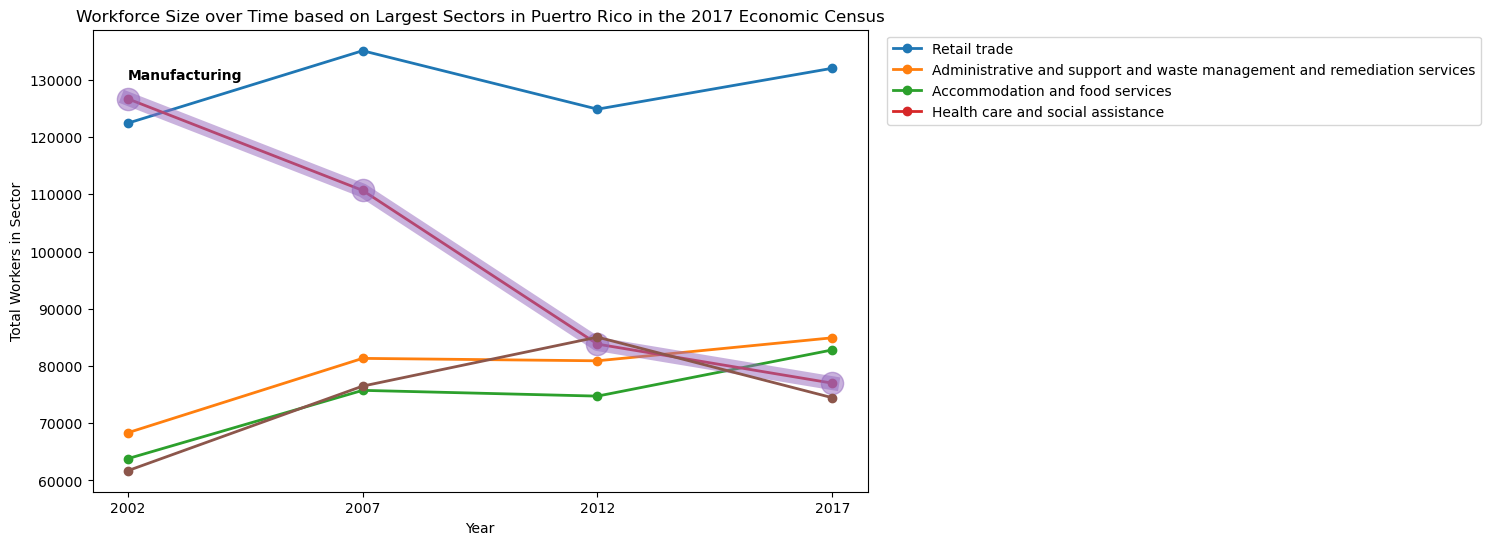

In [78]:
# plot data over time
plt.figure(figsize=(10,6))

# create a temporary dataframe to drop the summary row
sum_check = all_sectors_all_years['industry_code'] != '00'
pr_decline_graphic_df = all_sectors_all_years[sum_check]

labels = ['Retail trade','Administrative and support and waste management and remediation services',
         'Accommodation and food services', 'Health care and social assistance']

# loop over the industries and plot each of them over time as a unique line
for industry in pr_decline_graphic_df['industry_code'].unique():
    industry_data = pr_decline_graphic_df[pr_decline_graphic_df['industry_code'] == industry]
    industry_data = industry_data.sort_values('YEAR')
    years = industry_data['YEAR']
    employees = industry_data['employees']
    plt.plot(years, employees, label=industry, linewidth=2, linestyle='-', marker='o')
    
    # add larger width and shadow to make the Manufacturing decline pop
    if industry == '31-33':
        plt.plot(years, employees, label=industry, linewidth=10, alpha = 0.5, marker='o', markersize=16)
        #labels.append('Manufacturing')
        plt.text(2002, 132000, 'Manufacturing', ha='left', va='top', weight='bold')
        
plt.legend(labels, bbox_to_anchor=(1.8,1), loc='upper right')

plt.xlabel('Year')
plt.ylabel('Total Workers in Sector')
plt.xticks([2002,2007,2012,2017])
plt.title('Workforce Size over Time based on Largest Sectors in Puertro Rico in the 2017 Economic Census')

In [79]:
# remove excess columns without useful information
pr_decline_graphic_df = pr_decline_graphic_df.iloc[:,:10]

In [80]:
#pr_decline_graphic_df.to_csv('puerto_rico_employment_2002_2017.csv',index=False)

In [81]:
# finding the total percent change in manufacturing 
manufacturing_stats_df = pr_decline_graphic_df[pr_decline_graphic_df['industry'] == 'Manufacturing']
manuf_2002 = manufacturing_stats_df['employees'].iloc[-1]
manuf_2017 = manufacturing_stats_df['employees'].iloc[0]
percent_change_manuf = ((manuf_2017 - manuf_2002) / manuf_2002) * 100
print('The total percent change in PR in manufacturing across all available years is:', percent_change_manuf)

The total percent change in PR in manufacturing across all available years is: -39.22593069049066


In [87]:
# finding the total percent change in accomodation 
accomodation_stats_df = pr_decline_graphic_df[pr_decline_graphic_df['industry_code'] == '72']
accomodation_2002 = accomodation_stats_df['employees'].iloc[-1]
accomodation_2017 = accomodation_stats_df['employees'].iloc[0]
percent_change_accomodation = ((accomodation_2017 - accomodation_2002) / accomodation_2002) * 100
print('The total percent change in PR in accomodation across all available years is:', percent_change_accomodation)

The total percent change in PR in accomodation across all available years is: 29.783732957216735


In [90]:
# finding the total percent change in administration 
admin_stats_df = pr_decline_graphic_df[pr_decline_graphic_df['industry_code'] == '56']
admin_2002 = admin_stats_df['employees'].iloc[-1]
admin_2017 = admin_stats_df['employees'].iloc[0]
percent_change_admin = ((admin_2017 - admin_2002) / admin_2002) * 100
print('The total percent change in PR in administrative across all available years is:', percent_change_admin)

The total percent change in PR in administrative across all available years is: 20.676466298235095


In [83]:
pr_decline_graphic_df.sort_values(by='RCPTOT',ascending=False)

NAME       GEO_ID  \
658  Puerto Rico  0400000US72   
0    Puerto Rico          NaN   
1    Puerto Rico          NaN   
0    Puerto Rico    04000US72   
4    Puerto Rico    04000US72   
150  Puerto Rico  0400000US72   
3    Puerto Rico  0400000US72   
1    Puerto Rico    04000US72   
471  Puerto Rico  0400000US72   
13   Puerto Rico    04000US72   
9    Puerto Rico  0400000US72   
11   Puerto Rico    04000US72   
532  Puerto Rico  0400000US72   
14   Puerto Rico  0400000US72   
15   Puerto Rico    04000US72   
13   Puerto Rico    04000US72   
279  Puerto Rico  0400000US72   
11   Puerto Rico    04000US72   
11   Puerto Rico  0400000US72   
9    Puerto Rico    04000US72   

                                              industry industry_code  \
658                                      Manufacturing         31-33   
0                                        Manufacturing         31-33   
1                                        Manufacturing         31-33   
0                                        Manufacturing         31-33   
4                                         Retail trade         44-45   
150                                       Retail trade         44-45   
3                                         Retail trade         44-45   
1                                         Retail trade         44-45   
471                  Health care and social assistance            62   
13                   Health care and social assistance            62   
9                    Health care and social assistance            62   
11                     Health care & social assistance            62   
532                    Accommodation and food services            72   
14                     Accommodation and food services            72   
15                     Accommodation and food services            72   
13                     Accommodation and food services            72   
279  Administrative and support and waste managemen...            56   
11   Administrative and support and waste managemen...            56   
11   Administrative and support and waste managemen...            56   
9    Administrative and support and waste managemen...            56   

     locations  employees  firms  annual_payroll      RCPTOT  YEAR  
658     1739.0    77005.0    0.0       2854815.0  85263498.0  2017  
0       2151.0   110691.0    NaN       1918061.0  80172049.0  2007  
1       1653.0    83830.0    NaN       1646997.0  76575043.0  2012  
0          NaN   126707.0    NaN       3130631.0  58580060.0  2002  
4      11129.0   135099.0    NaN             NaN  26192445.0  2007  
150     9364.0   132033.0    0.0       2368082.0  25456248.0  2017  
3       9732.0   124887.0    NaN             NaN  24957584.0  2012  
1      11465.0   122435.0    NaN             NaN  20422975.0  2002  
471     7738.0    84933.0    0.0       2085097.0   7885285.0  2017  
13      6764.0    81337.0    NaN             NaN   6663318.0  2007  
9       7014.0    80913.0    NaN             NaN   6098340.0  2012  
11      6464.0    68338.0    NaN       1224260.0   4967317.0  2002  
532     4758.0    82815.0    0.0       1084616.0   4313196.0  2017  
14      4084.0    74741.0    NaN             NaN   4256139.0  2012  
15      4152.0    75748.0    NaN             NaN   3989750.0  2007  
13      4133.0    63810.0    NaN        732147.0   3360226.0  2002  
279     1884.0    74461.0    0.0       1445280.0   3197260.0  2017  
11      1774.0    76488.0    NaN             NaN   3178504.0  2007  
11      1644.0    85049.0    NaN             NaN   2948546.0  2012  
9       1724.0    61703.0    NaN        888063.0   2336978.0  2002

###### Comparing Manufacturing Decline Across Similar States 

GDP of Puerto Rico (2022): $111.067 billion [https://www.bea.gov/sites/default/files/2023-07/prgdp0723.pdf]

Population of Puerto Rico (2022): 3,285,874 [https://www.census.gov/geographies/island-areas/puerto-rico.html] 
  
  
  
Similar States (2022)  
By GDP:    
- Mississipi: 104,535.3   
- New Mexico: 94,663.4   
[https:\apps.bea.gov\itable\index.html?appid=70&stepnum=40&Major_Area=3&State=0&Area=XX&TableId=600&Statistic=1&Year=2022&YearBegin=-1&Year_End=-1&Unit_Of_Measure=Levels&Rank=1&Drill=1&nRange=5&AppId=70]
  
By Population:  
- Iowa: 3,200,517  
- Nevada: 3,177,772  
[https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html] 

In [45]:
def clean_for_comparison(df):
    # save the columns of interest in a list in a list
    industry_cols = ['NAICS2017_LABEL','NAICS2012_LABEL','NAICS2007_MEANING']
    # rename using comprehension and save over each label as a 'industry'
    rename_col = {col: 'industry' for col in industry_cols}
    return df.rename(columns=rename_col)

In [46]:
def fill_missing_industry(df):
    # save list of industries in a list
    unique_industries = df.loc[df['industry'].notnull(),'industry'].unique()
    for industry in unique_industries:
        # loop over the list and create a mask for the sector
        sector = df.loc[df['industry'] == industry, 'SECTOR'].iloc[0]
        # fill the nulls with the mask by matching to the sector name
        df.loc[df['industry'].isnull() & (df['SECTOR'] == sector), 'industry'] = industry   
    # clean old industry name before 2007
    df['industry'] = df['industry'].replace('Administrative and Support and Waste Mang and Remediation Srvs','Administrative and support and waste management and remediation services')
    return df    

In [47]:
# apply the custom functions above to each dataset and retain as seperate variables for later analysis

MS_02 = clean_for_comparison(econ_2002_mississippi)
MS_07 = clean_for_comparison(econ_2007_mississippi)
MS_12 = clean_for_comparison(econ_2012_mississippi)
MS_17 = clean_for_comparison(econ_2017_mississippi)
MS_total_df = fill_missing_industry(pd.concat([MS_02,MS_07,MS_12,MS_17])).reset_index(drop=True)

NM_02 = clean_for_comparison(econ_2002_new_mexico)
NM_07 = clean_for_comparison(econ_2007_new_mexico)
NM_12 = clean_for_comparison(econ_2012_new_mexico)
NM_17 = clean_for_comparison(econ_2017_new_mexico)
NM_total_df = fill_missing_industry(pd.concat([NM_02,NM_07,NM_12,NM_17])).reset_index(drop=True)

IA_02 = clean_for_comparison(econ_2002_iowa)
IA_07 = clean_for_comparison(econ_2007_iowa)
IA_12 = clean_for_comparison(econ_2012_iowa)
IA_17 = clean_for_comparison(econ_2017_iowa)
IA_total_df = fill_missing_industry(pd.concat([IA_02,IA_07,IA_12,IA_17])).reset_index(drop=True)

NV_02 = clean_for_comparison(econ_2002_nevada)
NV_07 = clean_for_comparison(econ_2007_nevada)
NV_12 = clean_for_comparison(econ_2012_nevada)
NV_17 = clean_for_comparison(econ_2017_nevada)
NV_total_df = fill_missing_industry(pd.concat([NV_02,NV_07,NV_12,NV_17])).reset_index(drop=True)

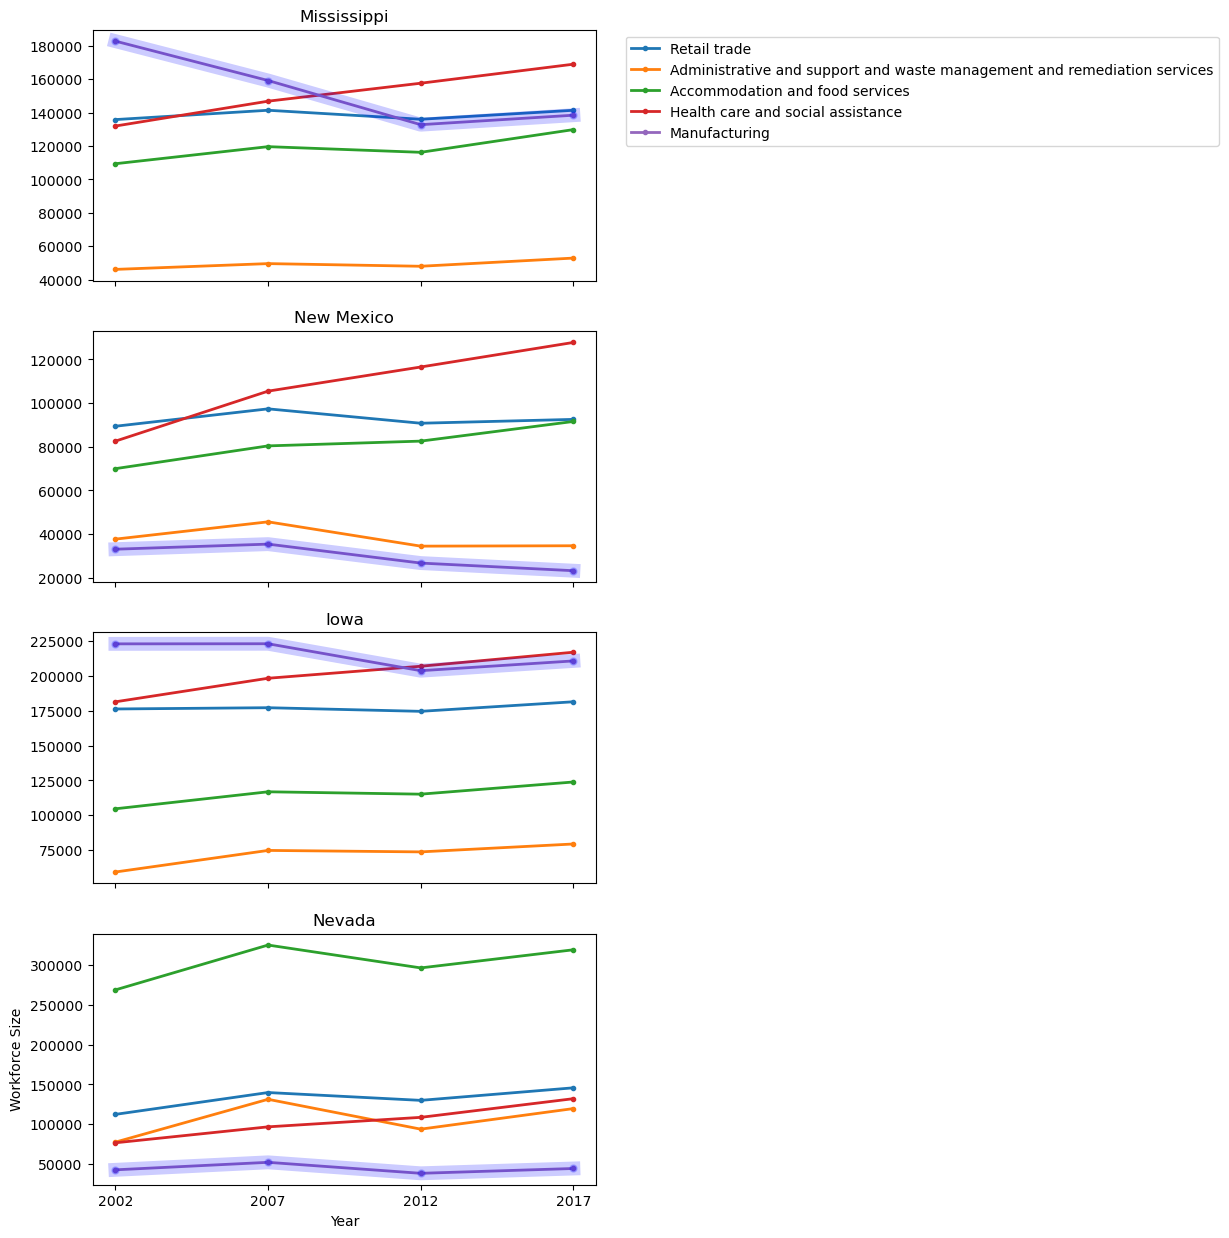

In [48]:
# plot all data over time facet wrapped

all_comp_states = pd.concat([MS_total_df,NM_total_df,IA_total_df,NV_total_df])

fips_to_states = {'28':'Mississippi','35':'New Mexico','19':'Iowa','32':'Nevada'}
all_comp_states['state'] = all_comp_states['state'].map(fips_to_states) 

states = all_comp_states['state'].unique()
labels = ['Retail trade','Administrative and support and waste management and remediation services',
         'Accommodation and food services', 'Health care and social assistance', 'Manufacturing']

fig, axes = plt.subplots(nrows=len(states), sharex=True, figsize=(6.5,15))

for i, state in enumerate(states):
    ax = axes[i]
    ax.set_title(state)
    
    state_data = all_comp_states[all_comp_states['state'] == state]
    
    for industry in labels:
        industry_data = state_data[state_data['industry'] == industry]
        ax.plot(industry_data['YEAR'], industry_data['EMP'], label=industry, linewidth=2, linestyle='-', marker='o', markersize=3)
        if industry == 'Manufacturing':
            ax.plot(industry_data['YEAR'], industry_data['EMP'], label=industry, linewidth=10, alpha=0.2, linestyle='-', color='blue', marker='o', markersize=5)
                
    if i == len(states)-1:
        ax.set_xlabel('YEAR')
    if i == 0:
        ax.legend(labels, bbox_to_anchor=(2.25,1), loc='upper right')
    ax.set_xticks([2002,2007,2012,2017])
    ax.set_title(state)
    plt.xlabel('Year')
    plt.ylabel('Workforce Size')
plt.show()

In [49]:
cols_to_drop_four_state_df = ['NAICS2002','OPTAX','GEO_ID','NAICS2007','NAME','NAICS2012','NAICS2017','FIRM']
all_comp_states = all_comp_states.drop(columns=cols_to_drop_four_state_df)

In [50]:
#all_comp_states.to_csv('four_states_all_sectors_2002_2017.csv',index=False)

###### Percent Change over Time

In [51]:
# standardize column names across years and industries for all states
comp_cols = ['EMP','ESTAB','PAYANN','RCPTOT','industry','YEAR','state']
states_all_years_all_sectors = all_comp_states[comp_cols]
states_all_years_all_sectors.rename(columns={'state':'NAME'},inplace=True)
states_all_years_all_sectors.reset_index(drop=True, inplace=True)

In [52]:
pr_comp_cols = {
    'employees':'EMP',
    'locations':'ESTAB',
    'annual_payroll':'PAYANN',
    'RCPTOT':'RCPTOT',
    'industry':'industry',
    'YEAR':'YEAR',
    'NAME':'NAME'
}
all_sectors_all_years = all_sectors_all_years.rename(columns=pr_comp_cols)
pr_comp_cols_names = list(pr_comp_cols.values())
columns_to_drop = [col for col in all_sectors_all_years.columns if col not in pr_comp_cols_names]
pr_cleaned_all = all_sectors_all_years.drop(columns=columns_to_drop)
pr_cleaned_all.reset_index(drop=True, inplace=True)

In [128]:
# save eeach percent change independently to plot and compare for analysis

manuf_pr = pr_cleaned_all[pr_cleaned_all['industry'] == 'Manufacturing'] 
manuf_states = states_all_years_all_sectors[states_all_years_all_sectors['industry'] == 'Manufacturing']

total_pr = pr_cleaned_all[pr_cleaned_all['industry'] == 'Total for all sectors'] 
total_states= states_all_years_all_sectors[states_all_years_all_sectors['industry'] == 'Total for all sectors']

manuf_ms = states_all_years_all_sectors[(states_all_years_all_sectors['industry'] == 'Manufacturing') & (states_all_years_all_sectors['NAME'] == 'Mississippi')]
manuf_nm = states_all_years_all_sectors[(states_all_years_all_sectors['industry'] == 'Manufacturing') & (states_all_years_all_sectors['NAME'] == 'New Mexico')]
manuf_ia = states_all_years_all_sectors[(states_all_years_all_sectors['industry'] == 'Manufacturing') & (states_all_years_all_sectors['NAME'] == 'Iowa')]
manuf_nv = states_all_years_all_sectors[(states_all_years_all_sectors['industry'] == 'Manufacturing') & (states_all_years_all_sectors['NAME'] == 'Nevada')]

total_ms = states_all_years_all_sectors[(states_all_years_all_sectors['industry'] == 'Total for all sectors') & (states_all_years_all_sectors['NAME'] == 'Mississippi')]
total_nm = states_all_years_all_sectors[(states_all_years_all_sectors['industry'] == 'Total for all sectors') & (states_all_years_all_sectors['NAME'] == 'New Mexico')]
total_ia = states_all_years_all_sectors[(states_all_years_all_sectors['industry'] == 'Total for all sectors') & (states_all_years_all_sectors['NAME'] == 'Iowa')]
total_nv = states_all_years_all_sectors[(states_all_years_all_sectors['industry'] == 'Total for all sectors') & (states_all_years_all_sectors['NAME'] == 'Nevada')]

analysis_cols = ['ESTAB','EMP','PAYANN','RCPTOT','PAYANN']
for col in analysis_cols:
    manuf_pr[col] = manuf_pr[col].astype(float)
    manuf_states[col] = manuf_states[col].astype(float)
    total_pr[col] = total_pr[col].astype(float)
    total_states[col] = total_states[col].astype(float)

manuf_pr_grouped = manuf_pr.groupby('YEAR').sum()
manuf_pr_grouped_pct = manuf_pr_grouped.pct_change() * 100

total_pr_grouped = total_pr.groupby('YEAR').sum()
total_pr_grouped_pct = total_pr_grouped.pct_change() * 100

manuf_states_grouped = manuf_states.groupby('YEAR').sum()
manuf_states_grouped_pct = manuf_states_grouped.pct_change() * 100

total_states_grouped = total_states.groupby('YEAR').sum()
total_states_grouped_pct = total_states_grouped.pct_change() * 100

manuf_pr_grouped_pct.fillna(0,inplace=True)
manuf_states_grouped_pct.fillna(0,inplace=True)

total_pr_grouped_pct.fillna(0,inplace=True)
total_states_grouped_pct.fillna(0,inplace=True)

manuf_ms_grouped = manuf_ms.groupby('YEAR').sum()
total_ms_grouped = total_ms.groupby('YEAR').sum()
manuf_nm_grouped = manuf_nm.groupby('YEAR').sum()
total_nm_grouped = total_nm.groupby('YEAR').sum()
manuf_ia_grouped = manuf_ia.groupby('YEAR').sum()
total_ia_grouped = total_ia.groupby('YEAR').sum()
manuf_nv_grouped = manuf_nv.groupby('YEAR').sum()
total_nv_grouped = total_nv.groupby('YEAR').sum()

manuf_ms_grouped_pct = manuf_ms_grouped.pct_change() * 100
total_ms_grouped_pct = total_ms_grouped.pct_change() * 100
manuf_nm_grouped_pct = manuf_nm_grouped.pct_change() * 100
total_nm_grouped_pct = total_nm_grouped.pct_change() * 100
manuf_ia_grouped_pct = manuf_ia_grouped.pct_change() * 100
total_ia_grouped_pct = total_ia_grouped.pct_change() * 100
manuf_nv_grouped_pct = manuf_nv_grouped.pct_change() * 100
total_nv_grouped_pct = total_nv_grouped.pct_change() * 100

manuf_ms_grouped_pct.fillna(0,inplace=True)
manuf_nm_grouped_pct.fillna(0,inplace=True)
manuf_ia_grouped_pct.fillna(0,inplace=True)
manuf_nv_grouped_pct.fillna(0,inplace=True)
total_ms_grouped_pct.fillna(0,inplace=True)
total_nm_grouped_pct.fillna(0,inplace=True)
total_ia_grouped_pct.fillna(0,inplace=True)
total_nv_grouped_pct.fillna(0,inplace=True)

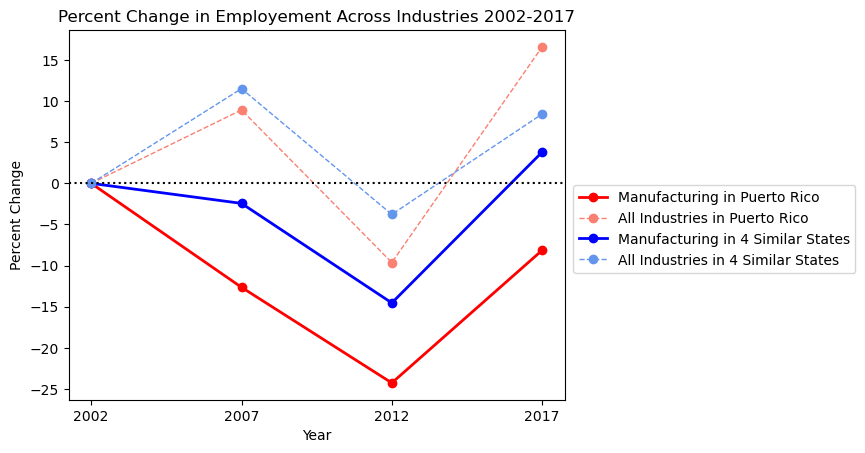

In [129]:
plt.plot(manuf_pr_grouped_pct.index, manuf_pr_grouped_pct['EMP'],label='Manufacturing in Puerto Rico', linewidth=2, linestyle='-', marker='o',color='Red')
plt.plot(total_pr_grouped_pct.index, total_pr_grouped_pct['EMP'],label='All Industries in Puerto Rico', linewidth=1, linestyle='--', marker='o', color='salmon')
plt.plot(manuf_states_grouped_pct.index, manuf_states_grouped_pct['EMP'],label='Manufacturing in 4 Similar States', linewidth=2, linestyle='-', marker='o',color='Blue')
plt.plot(total_states_grouped_pct.index, total_states_grouped_pct['EMP'],label='All Industries in 4 Similar States', linewidth=1, linestyle='--', marker='o',color='cornflowerblue')
plt.axhline(0,color='black',linestyle=':')
plt.xlabel('Year')
plt.xticks([2002,2007,2012,2017])
plt.ylabel('Percent Change')
plt.title('Percent Change in Employement Across Industries 2002-2017')
plt.legend(bbox_to_anchor=(1.6,0.6))
plt.show()

In [130]:
manuf_pr_grouped_pct['SECTOR'] = 'Manufacturing'
manuf_pr_grouped_pct['STATE'] = 'Puerto Rico' 
total_pr_grouped_pct['SECTOR'] = 'Total for All Sectors'
total_pr_grouped_pct['STATE'] = 'Puerto Rico' 

manuf_states_grouped_pct['SECTOR'] = 'Manufacturing'
manuf_states_grouped_pct['STATE'] = 'Four State Average'
total_states_grouped_pct['SECTOR'] = 'Total for All Sectors'
total_states_grouped_pct['STATE'] = 'Four State Average'

dfs_pct = [manuf_pr_grouped_pct, total_pr_grouped_pct, manuf_states_grouped_pct,total_states_grouped_pct]
for df in dfs_pct:
    df.reset_index(inplace=True)

'''
manuf_pr_grouped_pct.to_csv('percent_change_manufacturing_pr.csv',index=False)
total_pr_grouped_pct.to_csv('percent_change_all_sectors_pr.csv',index=False)
manuf_states_grouped_pct.to_csv('percent_change_manufacturing_four_state.csv',index=False)
total_states_grouped_pct.to_csv('percent_change_all_sectors_four_state.csv',index=False)
'''

## County Business Patterns

The County Business Patterns (CBP) series releases annual data on the number of establishments, employment during the week of March 12, first quarter payroll, and annual payroll. Data for Puerto Rico have been included since reference year 1998. Data are available by state- and county-equivalent level and at the 2- through 6-digit North American Industry Classification System (NAICS) industry detail.  

  
Data for this section is not pulled over time. This section covers data that could be hypothetically drawn for a business seeking insight on their industry. 


In [41]:
# evaluating the size of business establishments in Puerto Rico 

In [154]:
# pull data for all sectors from the API

cbp_2021_pr_api = 'https://api.census.gov/data/2021/cbp?get=NAME,NAICS2017_LABEL,LFO_LABEL,EMPSZES,EMPSZES_LABEL,ESTAB,PAYANN,EMP&for=state:72&NAICS2017=00&key=fe43695217081ac28642ce11f71882d406075d04'
cbp_2021_pr_r = requests.get(cbp_2021_pr_api)
cbp_2021_pr_j = cbp_2021_pr_r.json()
cbp_2021_pr_df = pd.DataFrame(cbp_2021_pr_j[1:],columns=cbp_2021_pr_j[0])

In [155]:
# transform numeric columns and drop the summary row

numeric_columns = ['ESTAB','PAYANN','EMP'] 
for column in numeric_columns:
    cbp_2021_pr_df[column] = cbp_2021_pr_df[column].astype(int)

cbp_2021_pr_df = cbp_2021_pr_df.drop(cbp_2021_pr_df[cbp_2021_pr_df['EMPSZES_LABEL'] == 'All establishments'].index)

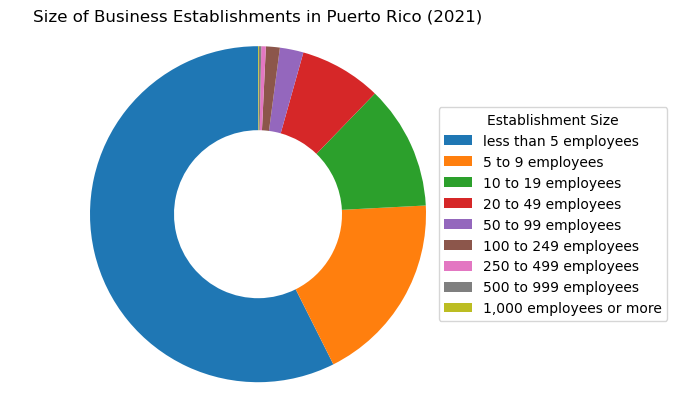

In [157]:
# create a wheel graphic for establishment size

sizes = cbp_2021_pr_df['ESTAB']
labels = cbp_2021_pr_df['EMPSZES_LABEL'].str.replace('Establishments with ','')

fig, ax = plt.subplots()
ax.pie(sizes, labels=None, startangle=90, wedgeprops=dict(width=0.5))
ax.legend(wedges, labels, loc='center left', bbox_to_anchor=(0.85,0.5), title='Establishment Size')
ax.axis('equal')

#percentages = [pct.get_text() for pct in autopct]

plt.title('Size of Business Establishments in Puerto Rico (2021)')

plt.show()

In [45]:
# Print largest organizations share
estab_over_1000 = cbp_2021_pr_df['ESTAB'].min()
print('There are only',estab_over_1000, 'business establishments in Puerto Rico with over 1,000 employees.')

There are only 38 business establishments in Puerto Rico with over 1,000 employees.


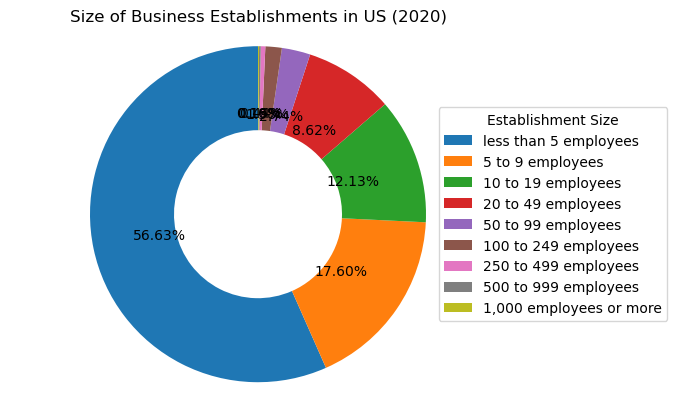

In [150]:
# Comparison to the US
# pull data for all sectors from the API

us_cbp_2021_pr_api = 'https://api.census.gov/data/2021/cbp?get=NAME,NAICS2017_LABEL,LFO_LABEL,EMPSZES,EMPSZES_LABEL,ESTAB,PAYANN,EMP&for=us:1&NAICS2017=00&key=fe43695217081ac28642ce11f71882d406075d04'
us_cbp_2021_pr_r = requests.get(us_cbp_2021_pr_api)
us_cbp_2021_pr_j = us_cbp_2021_pr_r.json()
us_cbp_2021_pr_df = pd.DataFrame(us_cbp_2021_pr_j[1:],columns=us_cbp_2021_pr_j[0])

numeric_columns = ['ESTAB','PAYANN','EMP'] 
for column in numeric_columns:
    us_cbp_2021_pr_df[column] = us_cbp_2021_pr_df[column].astype(float)

us_cbp_2021_pr_df = us_cbp_2021_pr_df.drop(us_cbp_2021_pr_df[us_cbp_2021_pr_df['EMPSZES_LABEL'] == 'All establishments'].index)

# create a wheel graphic for establishment size
sizes = us_cbp_2021_pr_df['ESTAB']
labels = us_cbp_2021_pr_df['EMPSZES_LABEL'].str.replace('Establishments with ','')

fig, ax = plt.subplots()
_,_,autopct = ax.pie(sizes, labels=None, startangle=90, autopct='%1.2f%%', wedgeprops=dict(width=0.5))
ax.legend(wedges, labels, loc='center left', bbox_to_anchor=(0.85,0.5), title='Establishment Size')
ax.axis('equal')

percentages = [pct.get_text() for pct in autopct]

plt.title('Size of Business Establishments in US (2021)')

plt.show()

In [142]:
# Print largest organizations share
us_estab_over_1000 = us_cbp_2021_pr_df['ESTAB'].min()
print('There are',us_estab_over_1000, 'business establishments in the U.S. with over 1,000 employees.')

There are 8365.0 business establishments in the U.S. with over 1,000 employees.


Breaking into an industry as a new business 

In [46]:
# pull all CBP data from 2021 on Puerto Rico on Accomodation sector

cbp_2021_pr_api = 'https://api.census.gov/data/2021/cbp?get=NAME,NAICS2017_LABEL,LFO_LABEL,EMPSZES,EMPSZES_LABEL,ESTAB,PAYANN,EMP,SECTOR&for=state:72&NAICS2017=721&key=fe43695217081ac28642ce11f71882d406075d04'
cbp_2021_pr_r = requests.get(cbp_2021_pr_api)
cbp_2021_pr_j = cbp_2021_pr_r.json()
cbp_2021_pr_df = pd.DataFrame(cbp_2021_pr_j[1:],columns=cbp_2021_pr_j[0])

In [47]:
# transform data columns

numeric_columns = ['ESTAB','PAYANN','EMP'] 
for column in numeric_columns:
    cbp_2021_pr_df[column] = cbp_2021_pr_df[column].astype(int)

In [48]:
# Retain only sector summary rows 

cbp_2021_pr_accomodation = cbp_2021_pr_df[cbp_2021_pr_df['NAICS2017'] == '721']      
cbp_2021_pr_accomodation['pay_per_employee'] = cbp_2021_pr_accomodation['PAYANN'] / cbp_2021_pr_accomodation['EMP']

In [49]:
# drop the total summary row 
cbp_2021_pr_accomodation_summary = cbp_2021_pr_accomodation[cbp_2021_pr_accomodation['EMPSZES_LABEL'] == 'All establishments']
cbp_2021_pr_accomodation = cbp_2021_pr_accomodation.drop(cbp_2021_pr_accomodation[cbp_2021_pr_accomodation['EMPSZES_LABEL'] == 'All establishments'].index)

Text(0.5, 1.0, 'Payroll per Employee across the Accomodation Sector Establishment Sizes in Puerto Rico (2021)')

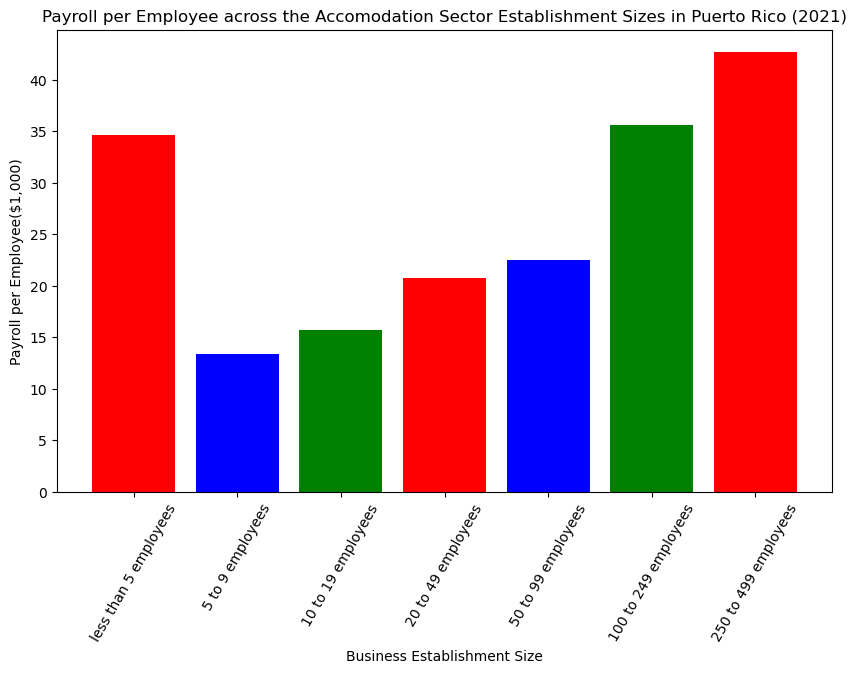

In [50]:
categories = cbp_2021_pr_accomodation['EMPSZES_LABEL'].str.replace('Establishments with ','')

plt.figure(figsize=(10,6))
plt.bar(categories, cbp_2021_pr_accomodation['pay_per_employee'], color=['red','blue','green'])
plt.xlabel('Business Establishment Size')
plt.ylabel('Payroll per Employee($1,000)') 
plt.xticks(rotation=60)
plt.title('Payroll per Employee across the Accomodation Sector Establishment Sizes in Puerto Rico (2021)')

In [51]:
average_pay = round(cbp_2021_pr_accomodation_summary['pay_per_employee'][0] * 1000, 2)

print('Puerto Rican Accomodation establishments provide lodging or short-term accommodations for travelers, vacationers, and more. On average, a new hotel would need to pay $', average_pay, 'per employee annually.') 

Puerto Rican Accomodation establishments provide lodging or short-term accommodations for travelers, vacationers, and more. On average, a new hotel would need to pay $ 31695.86 per employee annually.


In [52]:
# pull all CBP data from 2021 on Puerto Rico on Accomodation sector for geo_IDs

cbp_2021_pr_api = 'https://api.census.gov/data/2020/cbp?get=NAME,GEO_ID,NAICS2017_LABEL,ESTAB,PAYANN,PAYQTR1,EMP&for=county:*&in=state:72&NAICS2017=721&key=fe43695217081ac28642ce11f71882d406075d04'
cbp_2021_pr_r = requests.get(cbp_2021_pr_api)
cbp_2021_pr_j = cbp_2021_pr_r.json()
cbp_2021_pr_df = pd.DataFrame(cbp_2021_pr_j[1:],columns=cbp_2021_pr_j[0])

# transform data columns
numeric_columns = ['ESTAB','PAYANN','EMP','PAYQTR1'] 
for column in numeric_columns:
    cbp_2021_pr_df[column] = cbp_2021_pr_df[column].astype(int)
    
# pull the percent of businesses in San Juan 

total_estabs = cbp_2021_pr_df['ESTAB'].sum() 
estabs_in_SJPR = cbp_2021_pr_df[cbp_2021_pr_df['NAME'] == 'San Juan Municipio, Puerto Rico']['ESTAB'].values[0]
percent_in_SJPR = round(estabs_in_SJPR/total_estabs *100, 2)
print('Most accomodation businesses are concentrated in San Juan, the largest city.', percent_in_SJPR, '% of accomdation businesses are located in the San Juan Municipo.')

Most accomodation businesses are concentrated in San Juan, the largest city. 32.7 % of accomdation businesses are located in the San Juan Municipo.


## Business Trends and Outlooks

Business Trends and Outlooks Survey (BTOS) provides data for economic measures and business expectations about the future, especially after natural disasters and economic crises. BTOS samples 1.2 million businesses nationally, wherein a business is asked to report once every 12 weeks for a year.  
  
  
This section pulls data from the time before and after Hurricane Fiona. Hurricane Fiona officially occured between September 17 and 19 in Puerto Rico. 
https://www.weather.gov/sju/fiona2022

  


In [180]:
# read in the periods  
btos_periods ='https://www.census.gov/hfp/btos/api/periods'

periods = requests.get(btos_periods)
periods_table = periods.json()

periods_df = pd.DataFrame.from_dict(periods_table).T

### read in questions

btos_questions = 'https://www.census.gov/hfp/btos/api/questions'

questions = requests.get(btos_questions)
questions_table = questions.json()

questions_df = pd.DataFrame.from_dict(questions_table).T

In [186]:
periods_df

0                             1   \
PERIOD_ID                                    1                             2   
COLLECTION_START  18-JUL-22 12.00.00.000000 AM  01-AUG-22 12.00.00.000000 AM   
COLLECTION_END    31-JUL-22 12.00.00.000000 AM  14-AUG-22 12.00.00.000000 AM   
NAME                     7/18/2022 - 7/31/2022          8/1/2022 - 8/14/2022   

                                            2                             3   \
PERIOD_ID                                    3                             4   
COLLECTION_START  15-AUG-22 12.00.00.000000 AM  29-AUG-22 12.00.00.000000 AM   
COLLECTION_END    28-AUG-22 12.00.00.000000 AM  11-SEP-22 12.00.00.000000 AM   
NAME                     8/15/2022 - 8/28/2022         8/29/2022 - 9/11/2022   

                                            4                             5   \
PERIOD_ID                                    5                             7   
COLLECTION_START  12-SEP-22 12.00.00.000000 AM  10-OCT-22 12.00.00.000000 AM   
COLLECTION_END    25-SEP-22 12.00.00.000000 AM  23-OCT-22 12.00.00.000000 AM   
NAME                     9/12/2022 - 9/25/2022       10/10/2022 - 10/23/2022   

                                            6                             7   \
PERIOD_ID                                    8                            10   
COLLECTION_START  24-OCT-22 12.00.00.000000 AM  21-NOV-22 12.00.00.000000 AM   
COLLECTION_END    06-NOV-22 12.00.00.000000 AM  04-DEC-22 12.00.00.000000 AM   
NAME                    10/24/2022 - 11/6/2022        11/21/2022 - 12/4/2022   

                                            8                             9   \
PERIOD_ID                                   12                            13   
COLLECTION_START  19-DEC-22 12.00.00.000000 AM  02-JAN-23 12.00.00.000000 AM   
COLLECTION_END    01-JAN-23 12.00.00.000000 AM  15-JAN-23 12.00.00.000000 AM   
NAME                     12/19/2022 - 1/1/2023          1/2/2023 - 1/15/2023   

                  ...                            42  \
PERIOD_ID         ...                            43   
COLLECTION_START  ...  26-FEB-24 12.00.00.000000 AM   
COLLECTION_END    ...  11-MAR-24 12.00.00.000000 AM   
NAME              ...         2/26/2024 - 3/10/2024   

                                            43                            44  \
PERIOD_ID                                   44                            45   
COLLECTION_START  11-MAR-24 12.00.00.000000 AM  25-MAR-24 12.00.00.000000 AM   
COLLECTION_END    25-MAR-24 12.00.00.000000 AM  08-APR-24 12.00.00.000000 AM   
NAME                     3/11/2024 - 3/24/2024          3/25/2024 - 4/7/2024   

                                            45                            46  \
PERIOD_ID                                   46                            47   
COLLECTION_START  08-APR-24 12.00.00.000000 AM  22-APR-24 12.00.00.000000 AM   
COLLECTION_END    22-APR-24 12.00.00.000000 AM  06-MAY-24 12.00.00.000000 AM   
NAME                      4/8/2024 - 4/21/2024          4/22/2024 - 5/5/2024   

                                            47                            48  \
PERIOD_ID                                   48                            49   
COLLECTION_START  06-MAY-24 12.00.00.000000 AM  20-MAY-24 12.00.00.000000 AM   
COLLECTION_END    20-MAY-24 12.00.00.000000 AM  03-JUN-24 12.00.00.000000 AM   
NAME                      5/6/2024 - 5/19/2024          5/20/2024 - 6/2/2024   

                                            49                            50  \
PERIOD_ID                                   50                            51   
COLLECTION_START  03-JUN-24 12.00.00.000000 AM  17-JUN-24 12.00.00.000000 AM   
COLLECTION_END    17-JUN-24 12.00.00.000000 AM  01-JUL-24 12.00.00.000000 AM   
NAME                      6/3/2024 - 6/16/2024         6/17/2024 - 6/30/2024   

                                            51  
PERIOD_ID                                   52  
COLLECTION_START  01-JUL-24 12.00.00.000000 AM  
COLLECTION_E

In [181]:
# querying the API for four periods around Hurricane Fioana 

btos_pre_pre = 'https://www.census.gov/hfp/btos/api/periods/3/data/state/PR'
btos_pre_fiona ='https://www.census.gov/hfp/btos/api/periods/4/data/state/PR'
btos_post_fiona = 'https://www.census.gov/hfp/btos/api/periods/5/data/state/PR'
btos_post_post = 'https://www.census.gov/hfp/btos/api/periods/6/data/state/PR'
btos_post_post_post = 'https://www.census.gov/hfp/btos/api/periods/7/data/state/PR'

pr_btos_pre_pre = requests.get(btos_pre_pre)
pr_btos_pre = requests.get(btos_pre_fiona)
pr_btos_post = requests.get(btos_post_fiona)
pr_btos_post_post = requests.get(btos_post_post)
pr_btos_post_post_post = requests.get(btos_post_post_post)

pr_btos_pre_pre_data = pr_btos_pre_pre.json()
pr_btos_pre_data = pr_btos_pre.json()
pr_btos_post_data = pr_btos_post.json()
pr_btos_post_post_data = pr_btos_post_post.json()
pr_btos_post_post_post_data = pr_btos_post_post_post.json()


pr_btos_pre_pre_df = pd.DataFrame.from_dict(pr_btos_pre_pre_data).T
pr_btos_pre_df = pd.DataFrame.from_dict(pr_btos_pre_data).T
pr_btos_post_df = pd.DataFrame.from_dict(pr_btos_post_data).T
pr_btos_post_post_df = pd.DataFrame.from_dict(pr_btos_post_post_data).T
pr_btos_post_post_post_df = pd.DataFrame.from_dict(pr_btos_post_post_post_data).T

In [182]:
# merging all the time periods into one dataframe
pr_btos_full_fiona = pd.concat([pr_btos_pre_pre_df, pr_btos_pre_df,
                               pr_btos_post_df, pr_btos_post_post_df, pr_btos_post_post_post_df])

In [183]:
# filtering each questions for the topic of interest 

question_chains= pr_btos_full_fiona['OPTION_TEXT'] == 'Supply chain impacts'

pr_btos_chains_fiona = pr_btos_full_fiona[question_chains]

In [184]:
# transforming the date range for visualization 
pr_btos_chains_fiona[['start_date', 'end_date']] = pr_btos_chains_fiona['DATE_RANGE'].str.split(' - ', expand = True)

pr_btos_chains_fiona['start_date'] = pd.to_datetime(pr_btos_chains_fiona['start_date'], format ='%m/%d/%Y')
pr_btos_chains_fiona['end_date'] = pd.to_datetime(pr_btos_chains_fiona['end_date'], format ='%m/%d/%Y')

# transform the percentage of respondents to a float

pr_btos_chains_fiona['ESTIMATE_PERCENTAGE'] = pr_btos_chains_fiona['ESTIMATE_PERCENTAGE'].astype(float)

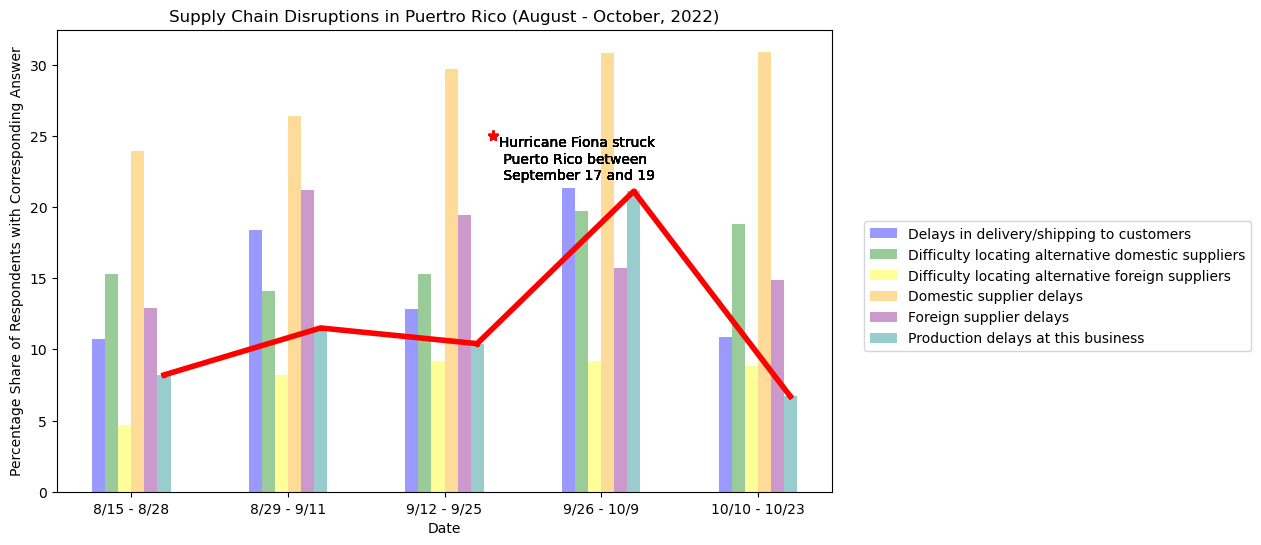

In [185]:
pivot_btos = pr_btos_chains_fiona.pivot(index='PERIOD_ID', columns='ANSWER', values='ESTIMATE_PERCENTAGE')

pivot_btos.drop('None of the above', axis=1, inplace=True)

answers = pivot_btos.columns
x = np.arange(len(pivot_btos.index))
total_width = 0.5
bar_width = total_width/len(answers)

target_answer = 'Production delays at this business'

bar_colors = ['blue', 'green', 'yellow', 'orange', 'purple','teal'] 

plt.figure(figsize=(10,6))
for i, answer in enumerate(answers):
    posistion = x + (i - (len(answers) - 1) / 2) * bar_width
    plt.bar(posistion, pivot_btos[answer], width=bar_width, color=bar_colors[i], alpha=0.4, label=answer)
    
    if answer == target_answer:
        plt.plot(posistion, pivot_btos[answer], marker = '.', linestyle='-', color='red', linewidth=4)
    plt.plot(2.31, 25, marker='*', markersize= '8', color='red')
    plt.text(2.35, 25, 'Hurricane Fiona struck \n Puerto Rico between \n September 17 and 19', ha='left', va='top')

plt.xlabel('Date')
plt.ylabel('Percentage Share of Respondents with Corresponding Answer')

custom_ticks = ['8/15 - 8/28', '8/29 - 9/11',
       '9/12 - 9/25', '9/26 - 10/9',
       '10/10 - 10/23'] 
plt.xticks(x,custom_ticks)
plt.legend(bbox_to_anchor=(1.55,0.6))
plt.title('Supply Chain Disruptions in Puertro Rico (August - October, 2022)')
plt.show()

##### COVID Recovery

This section attempts to find a pattern across all time frames. The closest pattern is that of Input Price changes. All other questions displayed no discernable pattern. 

In [232]:
# setting an empty list to append all periods to
btos_df_lst = []
base_url = 'https://www.census.gov/hfp/btos/api/periods/{}/data/state/PR'

# define the length of the call. 52 is the most recent period
start_period = 1
end_period = 26

for period in range(start_period, end_period + 1):
    url = base_url.format(period)
    response = requests.get(url)
    
    if response.status_code==200:
        data = response.json()
        # pull the data in from its dictionary raw json fromat
        loop_df = pd.DataFrame.from_dict(data).T
        # append to the empty list
        btos_df_lst.append(loop_df)
    else:
        print('error for period {period}')
    
    # add a delay to avoid time-outs
    time.sleep(1) 
    
#merge all datasets for the periods
all_btos_merged = pd.concat(btos_df_lst, ignore_index=True)        

In [260]:
# return only the data on the question theme 
all_btos_performance = all_btos_merged[all_btos_merged['OPTION_TEXT'] == 'Input prices'] 
all_btos_performance['ESTIMATE_PERCENTAGE'] = all_btos_performance['ESTIMATE_PERCENTAGE'].astype(float)

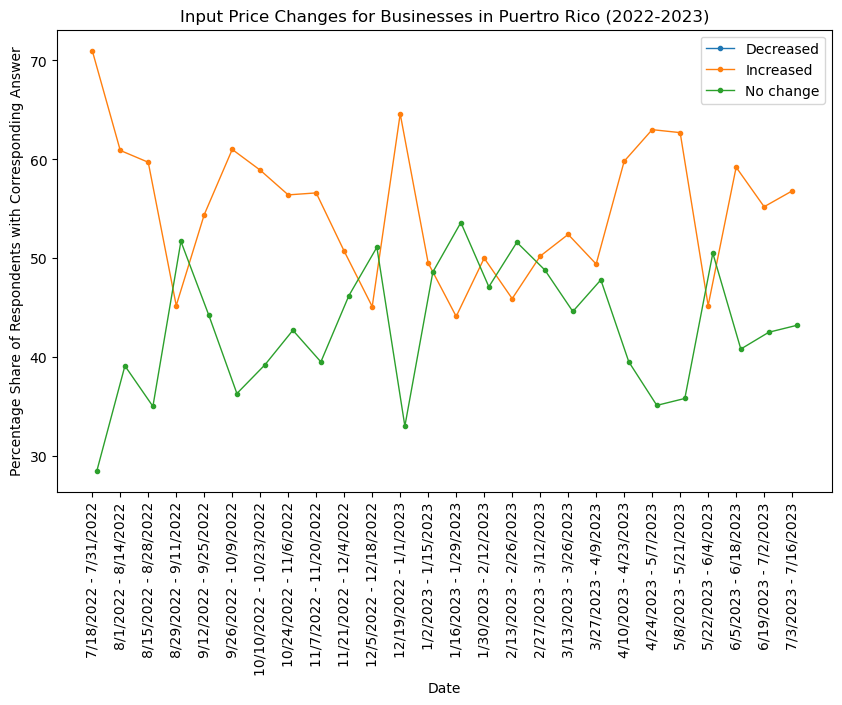

In [262]:
# plot the lines for each response category

all_btos_performance_pivot = all_btos_performance.pivot(index='PERIOD_ID', columns='ANSWER', values='ESTIMATE_PERCENTAGE')

answers = all_btos_performance_pivot.columns
x = np.arange(len(all_btos_performance_pivot.index))
total_width = 0.5
bar_width = total_width/len(answers)

plt.figure(figsize=(10,6))
for i, answer in enumerate(answers):
    posistion = x + (i - (len(answers) - 1) / 2) * bar_width
    plt.plot(posistion, all_btos_performance_pivot[answer], marker = '.', linestyle='-',  linewidth=1, label=answer)

plt.xlabel('Date')
plt.ylabel('Percentage Share of Respondents with Corresponding Answer')
plt.xticks(x,all_btos_performance['DATE_RANGE'].unique(),rotation=90)
plt.legend()
plt.title('Input Price Changes for Businesses in Puertro Rico (2022-2023)')
plt.show()

## International Trade Data

The U.S. Census Bureau is the official source for U.S. export and import goods statistics.  
  
Puerto Rico is a classified as a customs district within the U.S. customs territory and its trade with foreign countries is included in the U.S. export and import statistics. Census data on Puerto Rico also covers trade between the rest of the United States and the island.  
  
Statistics on shipments from the United States to Puerto Rico and shipments from Puerto Rico to the United States are compiled from information submitted in the Electronic Export Information filing (that must be filed with customs officials), and from shipments by qualified exporters who submit data directly to the Census Bureau.  
  
The Census Bureau also produces the “FT895: U.S. Trade with Puerto Rico and U.S. Possessions” report on an annual basis. The FT895 report provides data on shipments from the United States to Puerto Rico and from Puerto Rico to the United States by commodity (Schedule B) and by method of transportation. This annual report is typically released in the first half of the year following the reference year. 

This section explores export data from Puerto Rico.  

Note that FT895 is produced as a PDF ONLY, so top-level data is literally copied and pasted into this notebook

In [4]:
# setting the intitial API calls 
summary_of_exports_pr_2013_to_2022_api = 'https://api.census.gov/data/timeseries/intltrade/exports/statehs?get=STATE,ALL_VAL_MO,ALL_VAL_YR&key=fe43695217081ac28642ce11f71882d406075d04&time=from+2013-01+to+2022-12&STATE=PR'
pr_exports_by_destination_2013_to_2022_api = 'https://api.census.gov/data/timeseries/intltrade/exports/statehs?get=CTY_CODE,CTY_NAME,ALL_VAL_MO,ALL_VAL_YR&key=fe43695217081ac28642ce11f71882d406075d04&time=from+2013-01+to+2022-12&STATE=PR'
# ALL_VAL_MO = Total Value
# ALL_VAL_YR = Year to Date Total Value

In [5]:
def find_largest_export_destinations_pr():
    # call the API and pull the json
    ITD_pr_r = requests.get(pr_exports_by_destination_2013_to_2022_api)
    ITD_pr_j = ITD_pr_r.json()
    # transform into a dataframe
    ITD_pr_2013to2022to_df = pd.DataFrame(ITD_pr_j[1:],columns=ITD_pr_j[0])
    # update objects to their proper data type
    ITD_pr_2013to2022to_df['ALL_VAL_MO'] = ITD_pr_2013to2022to_df['ALL_VAL_MO'].astype(float)
    ITD_pr_2013to2022to_df['ALL_VAL_YR'] = ITD_pr_2013to2022to_df['ALL_VAL_YR'].astype(float)
    ITD_pr_2013to2022to_df['time'] = pd.to_datetime(ITD_pr_2013to2022to_df['time'], format = '%Y-%m')

    # drop the total summary row 
    ITD_pr_2013to2022to_sum = ITD_pr_2013to2022to_df[ITD_pr_2013to2022to_df['CTY_NAME'] == 'TOTAL FOR ALL COUNTRIES']
    ITD_pr_2013to2022to_df = ITD_pr_2013to2022to_df[ITD_pr_2013to2022to_df['CTY_NAME'] != 'TOTAL FOR ALL COUNTRIES']
    
    # drop the aggregated geographic areas
    geographic_areas = ['OECD', 'EUROPE', 'EUROPEAN UNION', 'NATO', 'EURO AREA', 'APEC', 'ASIA','PACIFIC RIM COUNTRIES',
                       'TWENTY LATIN AMERICAN REPUBLICS', 'NORTH AMERICA', 'NAFTA', 'CENTRAL AMERICA', 'LAFTA']
    for geo in geographic_areas:
        ITD_pr_2013to2022to_df = ITD_pr_2013to2022to_df[ITD_pr_2013to2022to_df['CTY_NAME'] != geo]
    
    # find the average value for trading partners
    average_exports = ITD_pr_2013to2022to_df.groupby('CTY_NAME')['ALL_VAL_YR'].mean()
    
    # sort the values in descending order
    average_exports = average_exports.sort_values(ascending=False)
   
    # take the top 10
    top_exports_markets = average_exports.head(10)
    
    print("Puerto Rico's largest export partner countries over the last nine years on a monthly average are: \n",top_exports_markets)

In [6]:
find_largest_export_destinations_pr()

Puerto Rico's largest export partner countries over the last nine years on a monthly average are: 
 CTY_NAME
NETHERLANDS       1.580043e+09
BELGIUM           1.262979e+09
ITALY             9.738233e+08
SPAIN             8.372149e+08
JAPAN             7.941714e+08
AUSTRIA           6.767696e+08
CHINA             5.056911e+08
GERMANY           4.942988e+08
CANADA            4.433171e+08
UNITED KINGDOM    3.681791e+08
Name: ALL_VAL_YR, dtype: float64


In [24]:
ITD_pr_r = requests.get(pr_exports_by_destination_2013_to_2022_api)
ITD_pr_j = ITD_pr_r.json()
# transform into a dataframe
ITD_pr_2013to2022to_df = pd.DataFrame(ITD_pr_j[1:],columns=ITD_pr_j[0])
# update objects to their proper data type
ITD_pr_2013to2022to_df['ALL_VAL_MO'] = ITD_pr_2013to2022to_df['ALL_VAL_MO'].astype(float)
ITD_pr_2013to2022to_df['ALL_VAL_YR'] = ITD_pr_2013to2022to_df['ALL_VAL_YR'].astype(float)
ITD_pr_2013to2022to_df['time'] = pd.to_datetime(ITD_pr_2013to2022to_df['time'], format = '%Y-%m')

# get the total summary row 
ITD_pr_2013to2022to_sum = ITD_pr_2013to2022to_df[ITD_pr_2013to2022to_df['CTY_NAME'] == 'TOTAL FOR ALL COUNTRIES']
ITD_pr_2013to2022to_sum_yr = ITD_pr_2013to2022to_sum[ITD_pr_2013to2022to_sum['time'].dt.month == 12].sort_values(by='time')

# filter data for world regions
geo_regions = ['AFRICA', 'NORTH AMERICA', 'SOUTH AMERICA', 'CENTRAL AMERICA', 'ASIA', 'EUROPE', 'AUSTRALIA AND OCEANIA'] 
ITD_pr_2013to2022to_df = ITD_pr_2013to2022to_df[ITD_pr_2013to2022to_df['CTY_NAME'].isin(geo_regions)]

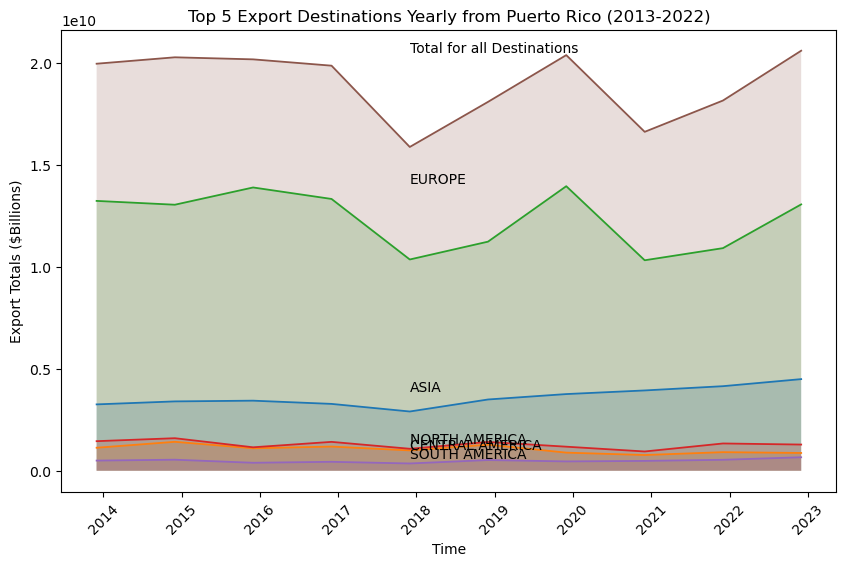

In [25]:
# reserve only the final month of the year to get the total for that year
ITD_pr_2013to2022to_df_yr = ITD_pr_2013to2022to_df[ITD_pr_2013to2022to_df['time'].dt.month == 12]

# filter only the top five export destinations
top_5_destinations_yrly = ITD_pr_2013to2022to_df_yr.groupby('CTY_NAME')['ALL_VAL_YR'].sum().nlargest(5).index
top_5_df_yrly = ITD_pr_2013to2022to_df_yr[ITD_pr_2013to2022to_df_yr['CTY_NAME'].isin(top_5_destinations_yrly)]
top_5_df_yrly = top_5_df_yrly.sort_values(['CTY_NAME', 'time'])

# plot the data
fig, ax = plt.subplots(figsize=(10,6))

for destination, data in top_5_df_yrly.groupby('CTY_NAME'):
    ax.plot(data['time'], data['ALL_VAL_YR'], label=destination, linewidth=1.3, linestyle='-')
    ax.fill_between(data['time'], data['ALL_VAL_YR'], alpha=0.2)
    ax.text(data['time'].iloc[4], data['ALL_VAL_YR'].iloc[-4], destination, ha='left', va='bottom')
plt.plot(ITD_pr_2013to2022to_sum_yr['time'], ITD_pr_2013to2022to_sum_yr['ALL_VAL_YR'], label='Total', linewidth=1.3, linestyle='-')
plt.fill_between(ITD_pr_2013to2022to_sum_yr['time'], ITD_pr_2013to2022to_sum_yr['ALL_VAL_YR'], alpha=0.2)
plt.text(ITD_pr_2013to2022to_sum_yr['time'].iloc[4], ITD_pr_2013to2022to_sum_yr['ALL_VAL_YR'].iloc[-4], 'Total for all Destinations', ha='left', va='bottom')

ax.set_xlabel('Time')
ax.set_ylabel('Export Totals ($Billions)')
ax.set_title('Top 5 Export Destinations Yearly from Puerto Rico (2013-2022)')
plt.xticks(rotation=45)
plt.show()

In [26]:
# data on exports from Puerto Rico to the United States is only avaiable from seperate PDF files for each year in the FT895
# the following values are copied and pasted into a dictionary from the pdf

pr_exports_to_usa_dict = {
    2022: 45072136000,        #table 3, page 369 https://www2.census.gov/library/publications/2023/economics/ft895-22.pdf
    2021: 43756897000,        #table 3, page 361 https://www2.census.gov/library/publications/2021/economics/ft895-21.pdf
    2020: 47054126000,        #table 3, page 358 https://www2.census.gov/library/publications/2021/economics/ft895-20.pdf
    2019: 48051726000,        #table 3, page 371 https://www2.census.gov/library/publications/2020/economics/ft895-19.pdf
    2018: 48507605000,        #table 3, page 364 https://www2.census.gov/library/publications/2019/economics/ft895-18.pdf
    2017: 51286634000,        #table 3, page 357 https://www.census.gov/content/dam/Census/library/publications/2018/econ/ft895-17.pdf 
    2016: 56136241000,        #table 3, page 357 https://www.census.gov/content/dam/Census/library/publications/2017/econ/ft895-16.pdf
    2015: 53281222000,        #table 3, page 357 https://www.census.gov/content/dam/Census/library/publications/2016/econ/ft895-15.pdf
    2014: 49194459000,        #table 3, page 357 https://www.census.gov/content/dam/Census/library/publications/2015/econ/ft895-14.pdf
    2013: 44228509000,        #table 3, page 364 https://www.census.gov/content/dam/Census/library/publications/2014/econ/ft895-13.pdf
}

pr_exports_to_usa_lst = [
['0XXX', 'UNITED STATES',0, 45072136000, '2022-12-01', 'PR'],
['0XXX', 'UNITED STATES',0, 43756897000, '2021-12-01', 'PR'],
['0XXX', 'UNITED STATES',0, 47054126000, '2020-12-01', 'PR'],
['0XXX', 'UNITED STATES',0, 48051726000, '2019-12-01', 'PR'],
['0XXX', 'UNITED STATES',0, 48507605000, '2018-12-01', 'PR'],
['0XXX', 'UNITED STATES',0, 51286634000, '2017-12-01', 'PR'],
['0XXX', 'UNITED STATES',0, 56136241000, '2016-12-01', 'PR'],
['0XXX', 'UNITED STATES',0, 53281222000, '2015-12-01', 'PR'],
['0XXX', 'UNITED STATES',0, 49194459000, '2014-12-01', 'PR'],
['0XXX', 'UNITED STATES',0, 44228509000, '2013-12-01', 'PR']]

In [27]:
# append the new row to the dataframe
new_rows_pr_to_usa = pd.DataFrame(pr_exports_to_usa_lst, columns= ITD_pr_2013to2022to_df_yr.columns)

new_rows_pr_to_usa['time'] = pd.to_datetime(new_rows_pr_to_usa['time'], format = '%Y-%m-%d')

ITD_pr_2013to2022to_df_yr = ITD_pr_2013to2022to_df_yr.append(new_rows_pr_to_usa, ignore_index=True)

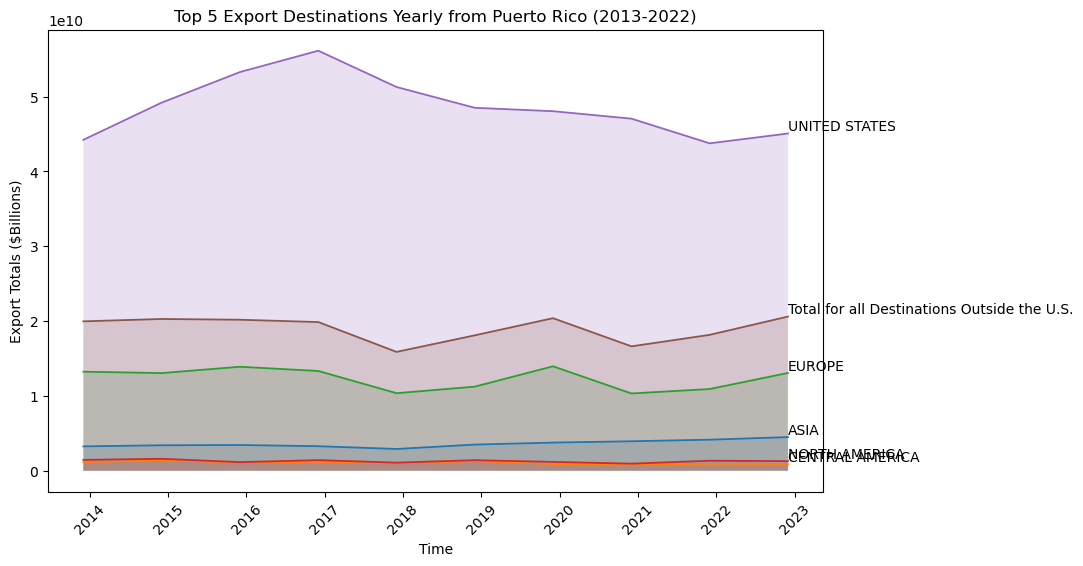

In [53]:
# repeat the process, but now include the United States 

top_5_destinations_yrly = ITD_pr_2013to2022to_df_yr.groupby('CTY_NAME')['ALL_VAL_YR'].sum().nlargest(5).index
top_5_df_yrly = ITD_pr_2013to2022to_df_yr[ITD_pr_2013to2022to_df_yr['CTY_NAME'].isin(top_5_destinations_yrly)]
top_5_df_yrly = top_5_df_yrly.sort_values(['CTY_NAME', 'time'])

# plot the data 
fig, ax = plt.subplots(figsize=(10,6))

for destination, data in top_5_df_yrly.groupby('CTY_NAME'):
    ax.plot(data['time'], data['ALL_VAL_YR'], label=destination, linewidth=1.3, linestyle='-')
    ax.fill_between(data['time'], data['ALL_VAL_YR'], alpha=0.2)
    ax.text(data['time'].iloc[-1], data['ALL_VAL_YR'].iloc[-1], destination, ha='left', va='bottom')
plt.plot(ITD_pr_2013to2022to_sum_yr['time'], ITD_pr_2013to2022to_sum_yr['ALL_VAL_YR'], label='Total', linewidth=1.3, linestyle='-')
plt.fill_between(ITD_pr_2013to2022to_sum_yr['time'], ITD_pr_2013to2022to_sum_yr['ALL_VAL_YR'], alpha=0.2)
plt.text(ITD_pr_2013to2022to_sum_yr['time'].iloc[-1], ITD_pr_2013to2022to_sum_yr['ALL_VAL_YR'].iloc[-1], s='Total for all Destinations Outside the U.S.', ha='left', va='bottom')

ax.set_xlabel('Time')
ax.set_ylabel('Export Totals ($Billions)')
ax.set_title('Top 5 Export Destinations Yearly from Puerto Rico (2013-2022)')
plt.xticks(rotation=45)
plt.show()

In [54]:
# Exports by Product 

# setting API for additional pull of HS code data
pr_exports_by_hs_2013_to_2022_api = 'https://api.census.gov/data/timeseries/intltrade/exports/statehs?get=E_COMMODITY,E_COMMODITY_LDESC,CTY_CODE,CTY_NAME,ALL_VAL_MO,ALL_VAL_YR&key=fe43695217081ac28642ce11f71882d406075d04&time=from+2013-01+to+2022-12&STATE=PR&COMM_LVL=HS2'

# pull in all exports by HS code for all months and destinations
hs_exports_pr_r = requests.get(pr_exports_by_hs_2013_to_2022_api)
hs_exports_pr_j = hs_exports_pr_r.json()

hs_exports_pr_2013to2022to_df = pd.DataFrame(hs_exports_pr_j[1:],columns=hs_exports_pr_j[0])

# transforming the variables from objects to the correct data type
hs_exports_pr_2013to2022to_df['ALL_VAL_MO'] = hs_exports_pr_2013to2022to_df['ALL_VAL_MO'].astype(float)
hs_exports_pr_2013to2022to_df['ALL_VAL_YR'] = hs_exports_pr_2013to2022to_df['ALL_VAL_YR'].astype(float)
hs_exports_pr_2013to2022to_df['time'] = pd.to_datetime(hs_exports_pr_2013to2022to_df['time'], format = '%Y-%m')

In [55]:
# filtering out all destinations to just the summaries
hs_exports_pr_2013to2022to_df_grouped = hs_exports_pr_2013to2022to_df[hs_exports_pr_2013to2022to_df['CTY_CODE']=='-']

In [56]:
# take the last five years average
last_five_years = range(2022 - 5, 2022)
hs_exports_pr_2013to2022to_df_grouped_5 = hs_exports_pr_2013to2022to_df_grouped[hs_exports_pr_2013to2022to_df_grouped['time'].dt.year.isin(last_five_years)]

# find the sum for each category
category_totals = hs_exports_pr_2013to2022to_df_grouped_5.groupby('E_COMMODITY_LDESC')['ALL_VAL_MO'].sum().reset_index()
category_totals_sorted = category_totals.sort_values(by='ALL_VAL_MO', ascending=False)
category_totals_sorted['TOTAL_EXPORT'] = category_totals_sorted['ALL_VAL_MO'].sum()
category_totals_sorted['EXPORT_NORMALIZED'] = category_totals_sorted['ALL_VAL_MO'] / category_totals_sorted['TOTAL_EXPORT']

top_4_categories_sorted = category_totals_sorted.head(3) 
all_others_combined = pd.DataFrame({
    'E_COMMODITY_LDESC': ['ALL OTHER EXPORTS COMBINED'],
    'ALL_VAL_MO': [category_totals_sorted.iloc[3:, category_totals_sorted.columns.get_loc('ALL_VAL_MO')].sum()]
})

all_others_combined['TOTAL_EXPORT'] = category_totals_sorted['TOTAL_EXPORT'][1] # setting equal total values
all_others_combined['EXPORT_NORMALIZED'] = all_others_combined['ALL_VAL_MO'] / all_others_combined['TOTAL_EXPORT']

export_pie_chart_df = pd.concat([top_4_categories_sorted,all_others_combined])


In [58]:
# rename the categories for readibility 
export_pie_chart_df .loc[export_pie_chart_df ['E_COMMODITY_LDESC'] == 'PHARMACEUTICAL PRODUCTS', 'E_COMMODITY_LDESC'] = 'Pharmaceuticals' 
export_pie_chart_df .loc[export_pie_chart_df ['E_COMMODITY_LDESC'] == 'ORGANIC CHEMICALS','E_COMMODITY_LDESC'] = 'Organic Chemicals' 
export_pie_chart_df .loc[export_pie_chart_df ['E_COMMODITY_LDESC'] == 'OPTICAL, PHOTOGRAPHIC, CINEMATOGRAPHIC, MEASURING, CHECKING, PRECISION, MEDICAL OR SURGICAL INSTRUMENTS AND APPARATUS; PARTS AND ACCESSORIES THEREOF', 'E_COMMODITY_LDESC'] = 'Specialized Percision Instruments' 
#export_pie_chart_df .loc[export_pie_chart_df ['E_COMMODITY_LDESC'] == 'ELECTRICAL MACHINERY AND EQUIPMENT AND PARTS THEREOF; SOUND RECORDERS AND REPRODUCERS, TELEVISION RECORDERS AND REPRODUCERS, PARTS AND ACCESSORIES', 'E_COMMODITY_LDESC'] = 'Electric Machinery' 
export_pie_chart_df .loc[export_pie_chart_df ['E_COMMODITY_LDESC'] == 'ALL OTHER EXPORTS COMBINED', 'E_COMMODITY_LDESC'] = 'All Other Exports Combined (91 Categories)' 

In [59]:
export_pie_chart_df ['EXPORT_NORMALIZED'] = round(export_pie_chart_df ['EXPORT_NORMALIZED'] * 100, 1)

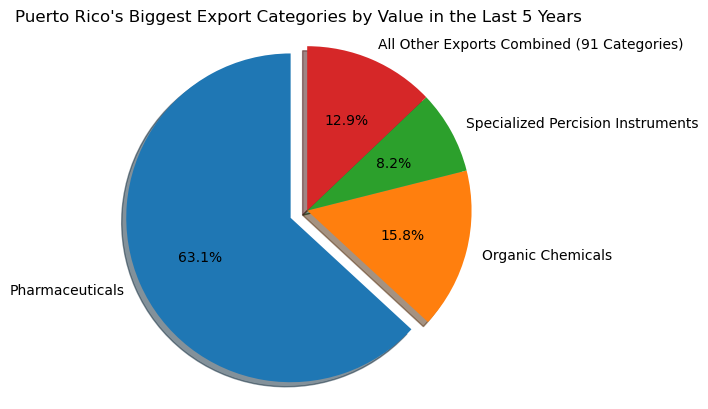

In [61]:
# plot the data, use explode to break out Phrama products 
explode = (0.11,0.0,0,0)
fig,ax=plt.subplots()
ax.pie(spider_chart_df['EXPORT_NORMALIZED'], explode=explode,labels=spider_chart_df['E_COMMODITY_LDESC'],
       shadow=True, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title("Puerto Rico's Biggest Export Categories by Value in the Last 5 Years")
plt.show()

In [19]:
Visualize # Pharma and Chemicals over time
# filter out all commodity categories other than pharma and chemicals
chem_pharma = ['PHARMACEUTICAL PRODUCTS','ORGANIC CHEMICALS']

hs_exports_pr_2013to2022to_df_chem_pharma =  hs_exports_pr_2013to2022to_df_grouped[hs_exports_pr_2013to2022to_df_grouped['E_COMMODITY_LDESC'].isin(chem_pharma)]

pharma_exports = hs_exports_pr_2013to2022to_df_chem_pharma[hs_exports_pr_2013to2022to_df_chem_pharma['E_COMMODITY_LDESC'] == 'PHARMACEUTICAL PRODUCTS']
chem_exports = hs_exports_pr_2013to2022to_df_chem_pharma[hs_exports_pr_2013to2022to_df_chem_pharma['E_COMMODITY_LDESC'] == 'ORGANIC CHEMICALS']

In [20]:
# aggregate by sum of the categories 
pharma_exports_grouped = pharma_exports.groupby('time').agg({'ALL_VAL_MO':sum, 'ALL_VAL_YR':sum}).reset_index()
chem_exports_grouped = chem_exports.groupby('time').agg({'ALL_VAL_MO':sum, 'ALL_VAL_YR':sum}).reset_index()

In [22]:
# retain only the total yearly value by taking the last month of the all_val_yr column
pharma_exports_grouped_yr = pharma_exports[pharma_exports['time'].dt.month == 12].sort_values(by='time')
chem_exports_grouped_yr = chem_exports[chem_exports['time'].dt.month == 12].sort_values(by='time')

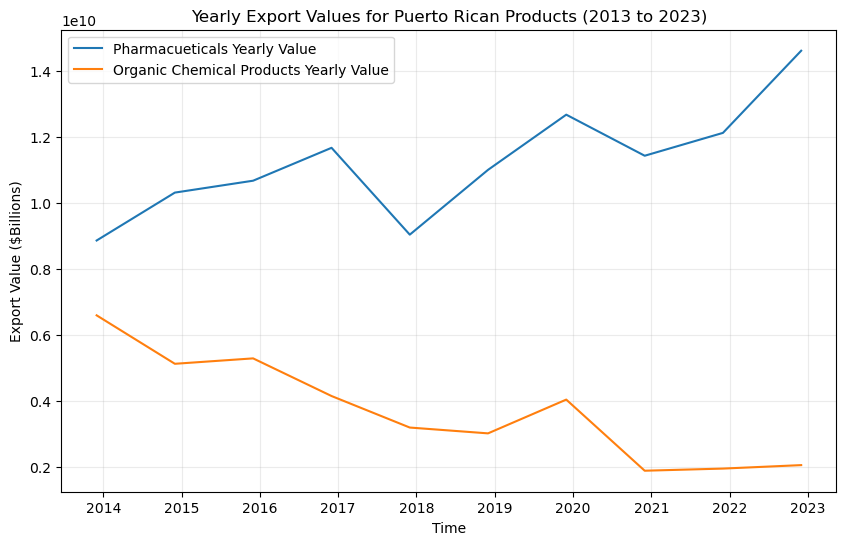

In [23]:
# plot the data over time, using the yearly value 
plt.figure(figsize=(10,6))
# plot each line on the same graphic
plt.plot(pharma_exports_grouped_yr['time'], pharma_exports_grouped_yr['ALL_VAL_YR'],label='Pharmacueticals Yearly Value')
plt.plot(chem_exports_grouped_yr['time'], chem_exports_grouped_yr['ALL_VAL_YR'],label='Organic Chemical Products Yearly Value')
plt.xlabel('Time')
plt.ylabel('Export Value ($Billions)')
plt.title('Yearly Export Values for Puerto Rican Products (2013 to 2023)')
plt.legend()
# set grid for readability 
plt.grid(True, alpha=0.25)
plt.show()

## Quarterly Workforce Indicators

Quarterly Workforce Indicators (QWI) are a product of the Longitudinal Employer-Household Dynamics (LEHD) program. LEHD produces cost effective, public-use information that combines federal, state and U.S. Census Bureau data on employers and employees. 


National-level data is constructed based on Longitudinal Employer-Household Dynamics data and is currently in a beta release only. Observations are compiled and published based on state-level data. They are only available by direct download from: https://ledextract.ces.census.gov/. This requires calling a CSV file for this section. 
  
  
This section pulls salaries and employment data for quarters over time. Information is pulled geographically to demonstrate differences, and data is aggregated across alll years for trends. 

In [2]:
def get_map_data():
    # pull in data for all quarters for 2020, 2021, and 2022
    qwi_api = 'https://api.census.gov/data/timeseries/qwi/rh?get=EarnS,geography&for=county:*&in=state:72&year=2020,2021,2022&quarter=1,2,3,4&key=fe43695217081ac28642ce11f71882d406075d04' 
    # transforming json to a dataframe
    qwi_pr_r = requests.get(qwi_api)
    qwi_pr_j = qwi_pr_r.json()
    qwi_pr_df = pd.DataFrame(qwi_pr_j[1:],columns=qwi_pr_j[0])
    # clean data files for manipulation
    qwi_pr_df['EarnS'] = qwi_pr_df['EarnS'].astype(float)
    qwi_pr_df['year'] = pd.to_datetime(qwi_pr_df['year'], format = '%Y')
    qwi_pr_df['quarter'] = qwi_pr_df['quarter'].astype(int)
    
    # pull the country codes for mapping 
    county_pr_codes = 'https://www2.census.gov/geo/docs/reference/codes2020/cou/st72_pr_cou2020.txt'

    state_lst = []
    county_fp_lst = []
    county_name_lst = []

    response = requests.get(county_pr_codes)
    if response.status_code == 200:
        lines = response.text.strip().split('\n')
        for line in lines:
            state, state_fp, county_fp, county_ns, county_name, class_fp, functstat = line.strip().split('|')
            county_fp_lst.append(county_fp)
            county_name_lst.append(county_name)

    data_fips_pr_dict = {
        'county' : county_fp_lst,
        'county_name' : county_name_lst
    }

    pr_municipos_names = pd.DataFrame(data_fips_pr_dict)
    pr_municipos_names.drop(0, inplace=True)
    
    # merge the dataframes 
    qwi_pr_df = pd.merge(qwi_pr_df,pr_municipos_names, on='county')
    
    # returning final data frame to be paired with shape file
    return qwi_pr_df

In [3]:
qwi_pr_df = get_map_data()

In [4]:
# find the average earnings across all years and quarters for each municipos
qwi_pr_df_grouped = qwi_pr_df.groupby(['county_name', 'geography'])['EarnS'].mean().reset_index()

In [5]:
print('Average salaries are highest in the following municipos: \n', qwi_pr_df_grouped.sort_values(by='EarnS', ascending=False).head(10))

Average salaries are highest in the following municipos: 
               county_name geography   EarnS
39       Juncos Municipio     72077  4395.2
30     Guaynabo Municipio     72061  3331.6
64     San Juan Municipio     72127  2946.6
65  San Lorenzo Municipio     72129  2942.2
2     Aguadilla Municipio     72005  2940.7
43  Las Piedras Municipio     72085  2793.4
46      ManatÃ­ Municipio     72091  2763.1
8   Barceloneta Municipio     72017  2762.8
31       Gurabo Municipio     72063  2758.9
16      CataÃ±o Municipio     72033  2708.9


In [6]:
print('Average salaries are lowest in the following municipos: \n', qwi_pr_df_grouped.sort_values(by='EarnS', ascending=False).tail(5))

Average salaries are lowest in the following municipos: 
                county_name geography   EarnS
11     Cabo Rojo Municipio     72023  1560.1
48       Maunabo Municipio     72095  1547.6
54      Orocovis Municipio     72107  1546.2
58  Quebradillas Municipio     72115  1537.1
42   Las MarÃ­as Municipio     72083  1331.2


In [92]:
print('Salaries are', round(4395.2 / 1331.2, 2), 'times larger in Juncos Municipio ($4395.2 monthly)- where Puerto Ricans have the highest average salary- compared to Las MarÃ­as Municipio ($1331.2 monthly)')

Salaries are 3.3 times larger in Juncos Municipio ($4395.2 monthly)- where Puerto Ricans have the highest average salary- compared to Las MarÃ­as Municipio ($1331.2 monthly)


In [4]:
# copied from https://www.census.gov/data/developers/data-sets/qwi.html#industry
industry_codes_dict = {
    '11':'Agriculture, Forestry, Fishing and Hunting',
    '21':'Mining, Quarrying, and Oil and Gas Extraction',
    '22':'Utilities',
    '23':'Construction',
    '31-33':'Manufacturing',
    '42':'Wholesale Trade',
    '44-45':'Retail Trade',
    '48-49':'Transportation and Warehousing',
    '51':'Information',
    '52':'Finance and Insurance',
    '53':'Real Estate and Rental and Leasing',
    '54':'Professional, Scientific, and Technical Services',
    '55':'Management of Companies and Enterprises',
    '56':'Administrative and Support and Waste Management and Remediation Services',
    '61':'Educational Services',
    '62':'Health Care and Social Assistance',
    '71':'Arts, Entertainment, and Recreation',
    '72':'Accommodation and Food Services',
    '81':'Other Services (except Public Administration)',
    '92':'Public Administration'
}

education_codes_dict ={
    'E0':"All Education Categories",
    'E1':"Less than high school",
    'E2':"High school or equivalent, no college",
    'E3':"Some college or Associate degree",
    'E4':"Bachelor's degree or advanced degree",
    'E5':"Educational attainment not available (workers aged 24 or younger)"
}

sex_codes_dict ={
    '0':"All Sexes",
    '1':"Male",
    '2':"Female"
}

In [13]:
# pull data on hiring for all available years and quarters 
qwi_hires_api = 'https://api.census.gov/data/timeseries/qwi/rh?get=HirAs,HirN,HirNs,Emp,EmpS,industry&for=state:72&year=2013,2014,2015,2016,2017,2018,2019,2020,2021,2022&quarter=1,2,3,4&ind_level=S&key=fe43695217081ac28642ce11f71882d406075d04' 

qwi_hires_r = requests.get(qwi_hires_api)
qwi_hires_j = qwi_hires_r.json()
qwi_hires_df = pd.DataFrame(qwi_hires_j[1:],columns=qwi_hires_j[0])

# transform the data for plotting 
qwi_hires_df['HirAs'] = qwi_hires_df['HirAs'].astype(float)
qwi_hires_df['HirNs'] = qwi_hires_df['HirNs'].astype(float)
qwi_hires_df['HirN'] = qwi_hires_df['HirN'].astype(float)
qwi_hires_df['Emp'] = qwi_hires_df['Emp'].astype(float)
qwi_hires_df['EmpS'] = qwi_hires_df['EmpS'].astype(float)

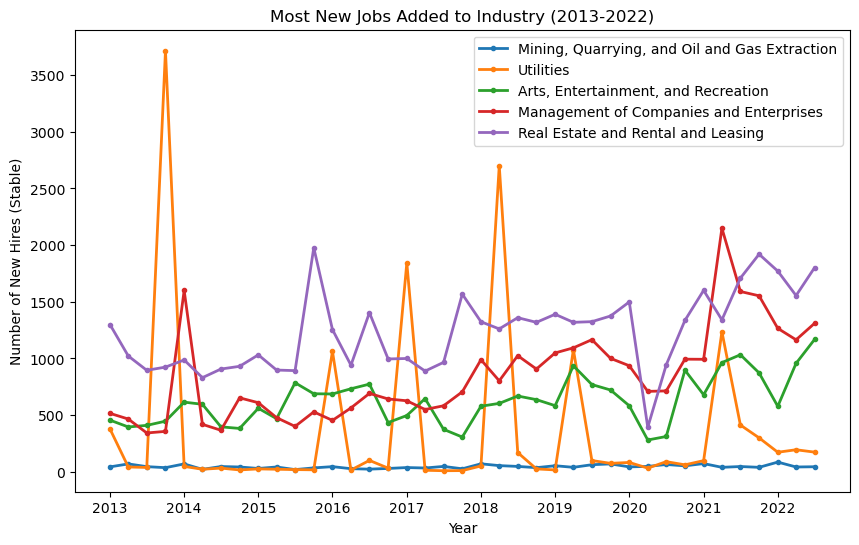

In [16]:
top_5_hires = qwi_hires_df.groupby('industry_label').mean().sort_values(by='yearly_hiring_average', ascending=True).head(5).index

# plot the data 
plt.figure(figsize=(10,6))
for industry in top_5_hires:
    industry_df = qwi_hires_df[qwi_hires_df['industry_label'] == industry].sort_values(by='date',ascending=True)
    plt.plot(industry_df['date'], industry_df['HirN'], label=industry, linewidth=2, marker='.',linestyle='-')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of New Hires (Stable)')
plt.title('Most New Jobs Added to Industry (2013-2022)')
plt.show()

In [5]:
# pull the data on job changes over all available time by education type 

qwi_change_url = 'https://api.census.gov/data/timeseries/qwi/se?get=FrmJbGn,FrmJbGnS,FrmJbCS,Emp,education&for=state:72&year=2013,2014,2015,2016,2017,2018,2019,2020,2021,2022&quarter=1,2,3,4&key=fe43695217081ac28642ce11f71882d406075d04' 

qwi_change_r = requests.get(qwi_change_url)
qwi_change_j = qwi_change_r.json()
qwi_change_df = pd.DataFrame(qwi_change_j[1:],columns=qwi_change_j[0])

# transform data into plotable data types
qwi_change_df['Firm_Job_Gain_Count'] = qwi_change_df['FrmJbGn'].astype(float)
qwi_change_df['Firm_Stable_Job_Gain_Count'] = qwi_change_df['FrmJbGnS'].astype(float)
qwi_change_df['Firm_Job_Change_Stable'] = qwi_change_df['FrmJbCS'].astype(float)
qwi_change_df['Employees'] = qwi_change_df['Emp'].astype(float)


In [6]:
# generate a date column that can be mapped and stored heirarchically 
qwi_change_df['Date'] = pd.to_datetime(qwi_change_df['year'].astype(str) + 'Q' + qwi_change_df['quarter'].astype(str))
# map on the 
qwi_change_df['Education_Label'] = qwi_change_df['education'].map(education_codes_dict)

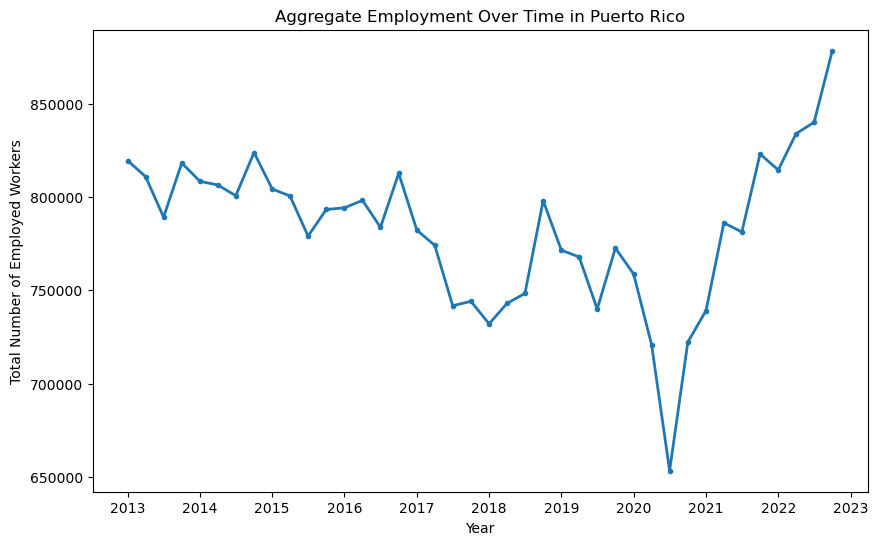

In [7]:
# since data on education types is not available, plot the aggregate for all education types to view employment over time
plt.figure(figsize=(10,6))
for edu in qwi_change_df['Education_Label'].unique():
    edu_df = qwi_change_df[qwi_change_df['Education_Label'] == edu].sort_values(by='Date',ascending=True)
    plt.plot(edu_df['Date'], edu_df['Employees'], label=edu, linewidth=2, marker='.',linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Number of Employed Workers')
plt.title('Aggregate Employment Over Time in Puerto Rico')
plt.show()

In [9]:
# pull all available data, broken out by sex for Puerto Rico
pr_qwi_test_url = 'https://api.census.gov/data/timeseries/qwi/se?get=EarnS,EarnBeg,EarnHirAS,sex&for=state:72&year=2013,2014,2015,2016,2017,2018,2019,2020,2021,2022&quarter=1,2,3,4&key=fe43695217081ac28642ce11f71882d406075d04' 

pr_qwi_test_r = requests.get(pr_qwi_test_url)
pr_qwi_test_j = pr_qwi_test_r.json()
pr_qwi_test_df = pd.DataFrame(pr_qwi_test_j[1:],columns=pr_qwi_test_j[0])

# repeat the pull for a simimlar state for comparison 
nm_qwi_test_url = 'https://api.census.gov/data/timeseries/qwi/se?get=EarnS,EarnBeg,EarnHirAS,sex&for=state:32&year=2013,2014,2015,2016,2017,2018,2019,2020,2021,2022&quarter=1,2,3,4&key=fe43695217081ac28642ce11f71882d406075d04' 

nm_qwi_test_r = requests.get(nm_qwi_test_url)
nm_qwi_test_j = nm_qwi_test_r.json()
nm_qwi_test_df = pd.DataFrame(nm_qwi_test_j[1:],columns=nm_qwi_test_j[0])


In [10]:
# transform the data for plotting

pr_qwi_test_df['Full Quarter Employment (Stable): Average Monthly Earnings'] = pr_qwi_test_df['EarnS'].astype(float)
pr_qwi_test_df['End-of-Quarter Employment: Average Monthly Earnings'] = pr_qwi_test_df['EarnBeg'].astype(float)
pr_qwi_test_df['Hires All (Stable): Average Monthly Earnings'] = pr_qwi_test_df['EarnHirAS'].astype(float)

# generate the stable date column 
pr_qwi_test_df['Date'] = pd.to_datetime(pr_qwi_test_df['year'].astype(str) + 'Q' + pr_qwi_test_df['quarter'].astype(str))

# map the sex codes to the gender identifier 
pr_qwi_test_df['Gender'] = pr_qwi_test_df['sex'].map(sex_codes_dict)

nm_qwi_test_df['Full Quarter Employment (Stable): Average Monthly Earnings'] = nm_qwi_test_df['EarnS'].astype(float)
nm_qwi_test_df['End-of-Quarter Employment: Average Monthly Earnings'] = nm_qwi_test_df['EarnBeg'].astype(float)
nm_qwi_test_df['Hires All (Stable): Average Monthly Earnings'] = nm_qwi_test_df['EarnHirAS'].astype(float)

nm_qwi_test_df['Date'] = pd.to_datetime(nm_qwi_test_df['year'].astype(str) + 'Q' + nm_qwi_test_df['quarter'].astype(str))

nm_qwi_test_df['Gender'] = nm_qwi_test_df['sex'].map(sex_codes_dict)

In [22]:
# remove the aggregate row for plotting, but save it for analysis
nm_qwi_all_sexes = nm_qwi_test_df[nm_qwi_test_df['Gender'] == 'All Sexes']
pr_qwi_all_sexes = pr_qwi_test_df[pr_qwi_test_df['Gender'] == 'All Sexes']
nm_qwi_test_df = nm_qwi_test_df[nm_qwi_test_df['Gender'] != 'All Sexes']
pr_qwi_test_df = pr_qwi_test_df[pr_qwi_test_df['Gender'] != 'All Sexes']

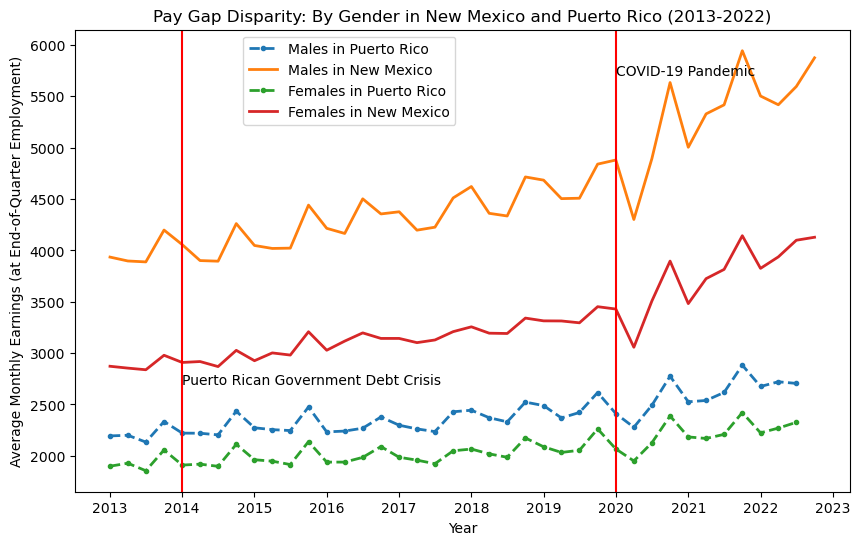

In [23]:
# generate date variables to create vertical lines on graphic 
pandemic = pd.to_datetime('2020-01-01')
PR_govt_debt_crisis = pd.to_datetime('2014-01-01')

# plot the data for Puerto Rico and New Mexico seperately 
plt.figure(figsize=(10,6))
for gender in pr_qwi_test_df['Gender'].unique():
    pr_gender_df = pr_qwi_test_df[pr_qwi_test_df['Gender'] == gender].sort_values(by='Date',ascending=True)
    plt.plot(pr_gender_df['Date'], pr_gender_df['End-of-Quarter Employment: Average Monthly Earnings'], label=gender + 's in Puerto Rico', linewidth=2, marker='.',linestyle='--')
    nm_gender_df = nm_qwi_test_df[nm_qwi_test_df['Gender'] == gender].sort_values(by='Date', ascending=True)
    plt.plot(nm_gender_df['Date'], nm_gender_df['End-of-Quarter Employment: Average Monthly Earnings'], label=gender + 's in New Mexico', linewidth=2,linestyle='-')

plt.axvline(x=pandemic, color='red')
plt.text(pandemic, 5700, 'COVID-19 Pandemic')
plt.axvline(x=PR_govt_debt_crisis, color='red')
plt.text(PR_govt_debt_crisis, 2700, 'Puerto Rican Government Debt Crisis')
plt.xlabel('Year')
plt.ylabel('Average Monthly Earnings (at End-of-Quarter Employment)')
plt.title('Pay Gap Disparity: By Gender in New Mexico and Puerto Rico (2013-2022)')
plt.legend(bbox_to_anchor=(0.5,1), loc='upper right')
plt.show()

In [24]:
# print the pay gap for all genders between New Mexico and Puerto Rico 
nm_qwi_all_sexes_2022 = nm_qwi_all_sexes[nm_qwi_all_sexes['year'] == '2022']
pr_qwi_all_sexes_2022 = pr_qwi_all_sexes[pr_qwi_all_sexes['year'] == '2022']

# average across all quarters 
nm_2022_avg_earnings = nm_qwi_all_sexes_2022['End-of-Quarter Employment: Average Monthly Earnings'].mean()
pr_2022_avg_earnings = pr_qwi_all_sexes_2022['End-of-Quarter Employment: Average Monthly Earnings'].mean()

pay_gap_2022 = (nm_2022_avg_earnings / pr_2022_avg_earnings)

print('New Mexico workers earned,', pay_gap_2022, 'more than Puerto Rican workers in 2022.')

New Mexico workers earned, 1.9424315619967794 more than Puerto Rican workers in 2022.


In [65]:
# data must be downlaoded fromhttps://ledextract.ces.census.gov/ 

us_qwi_df = pd.read_csv('qwi_us_2013_2022.csv', encoding='latin-1')

# transform data types
us_qwi_df['Full Quarter Employment (Stable): Average Monthly Earnings'] = us_qwi_df['EarnS'].astype(float)
us_qwi_df['End-of-Quarter Employment: Average Monthly Earnings'] = us_qwi_df['EarnBeg'].astype(float)
us_qwi_df['Hires All (Stable): Average Monthly Earnings'] = us_qwi_df['EarnHirAS'].astype(float)
us_qwi_df['sex'] = us_qwi_df['sex'].astype(str)

# generate stable date column for plotting
us_qwi_df['Date'] = pd.to_datetime(us_qwi_df['year'].astype(str) + 'Q' + us_qwi_df['quarter'].astype(str))

# map genders for plotting
us_qwi_df['Gender'] = us_qwi_df['sex'].map(sex_codes_dict)

us_qwi_df_all_sexes = us_qwi_df[us_qwi_df['Gender'] == 'All Sexes']
us_qwi_df = us_qwi_df[us_qwi_df['Gender'] != 'All Sexes']

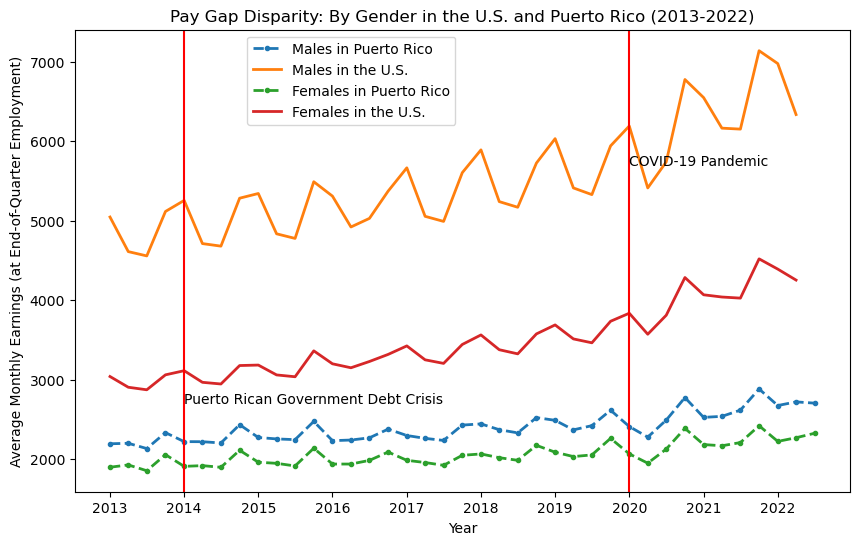

In [88]:
# repeat the graphic above for the whole United States 
pandemic = pd.to_datetime('2020-01-01')
PR_govt_debt_crisis = pd.to_datetime('2014-01-01')
date_2022 = pd.to_datetime('2022-01-01')

plt.figure(figsize=(10,6))
for gender in pr_qwi_test_df['Gender'].unique():
    pr_gender_df = pr_qwi_test_df[pr_qwi_test_df['Gender'] == gender].sort_values(by='Date',ascending=True)
    plt.plot(pr_gender_df['Date'], pr_gender_df['End-of-Quarter Employment: Average Monthly Earnings'], label=gender + 's in Puerto Rico', linewidth=2, marker='.',linestyle='--')
    us_gender_df = us_qwi_df[us_qwi_df['Gender'] == gender].sort_values(by='Date', ascending=True)
    plt.plot(us_gender_df['Date'], us_gender_df['End-of-Quarter Employment: Average Monthly Earnings'], label=gender + 's in the U.S.', linewidth=2,linestyle='-')

plt.axvline(x=pandemic, color='red')
plt.text(pandemic, 5700, 'COVID-19 Pandemic')
plt.axvline(x=PR_govt_debt_crisis, color='red')
plt.text(PR_govt_debt_crisis, 2700, 'Puerto Rican Government Debt Crisis')
plt.xlabel('Year')
plt.ylabel('Average Monthly Earnings (at End-of-Quarter Employment)')
plt.title('Pay Gap Disparity: By Gender in the U.S. and Puerto Rico (2013-2022)')
plt.legend(bbox_to_anchor=(0.5,1), loc='upper right')
plt.show()

In [70]:
# print the pay gap between the United States and Puerto Rico 
us_qwi_df_all_sexes_2022 = us_qwi_df_all_sexes[us_qwi_df_all_sexes['year'] == 2022]
pr_qwi_all_sexes_2022 = pr_qwi_all_sexes[pr_qwi_all_sexes['year'] == '2022']

us_2022_avg_earnings = us_qwi_df_all_sexes_2022['End-of-Quarter Employment: Average Monthly Earnings'].mean()
pr_2022_avg_earnings = pr_qwi_all_sexes_2022['End-of-Quarter Employment: Average Monthly Earnings'].mean()

us_pay_gap_2022 = (us_2022_avg_earnings / pr_2022_avg_earnings)

print('American workers earned,', us_pay_gap_2022 , 'more than Puerto Rican workers in 2022.')

American workers earned, 2.223429951690821 more than Puerto Rican workers in 2022.


In [91]:
# print the percent change between the pandemic and the start of 2022
pandemic_avg_earn_us = us_qwi_df_all_sexes[us_qwi_df_all_sexes['Date'] == pandemic].iloc[0]['End-of-Quarter Employment: Average Monthly Earnings'] 
most_recent_avg_earn_us = us_qwi_df_all_sexes[us_qwi_df_all_sexes['Date'] == final_date].iloc[0]['End-of-Quarter Employment: Average Monthly Earnings'] 

pandemic_avg_earn_pr = pr_qwi_all_sexes[pr_qwi_all_sexes['Date'] == pandemic].iloc[0]['End-of-Quarter Employment: Average Monthly Earnings'] 
most_recent_avg_earn_pr = pr_qwi_all_sexes[pr_qwi_all_sexes['Date'] == date_2022].iloc[0]['End-of-Quarter Employment: Average Monthly Earnings'] 

us_earn_pct_change = ((most_recent_avg_earn_us - pandemic_avg_earn_us) / pandemic_avg_earn_us) * 100
pr_earn_pct_change = ((most_recent_avg_earn_pr - pandemic_avg_earn_pr) / pandemic_avg_earn_pr) * 100

print('The U.S. experience a', us_earn_pct_change ,'percent change in earnings between the pandemic and Q1 2022')
print('Puerto Rico experience a', pr_earn_pct_change ,'percent change in earnings between the pandemic and Q1 2022')

The U.S. experience a 5.550049554013875 percent change in earnings between the pandemic and Q1 2022
Puerto Rico experience a 9.046345811051694 percent change in earnings between the pandemic and Q1 2022


In [145]:
def get_county_qwi_data(url):
    qwi_pr_r = requests.get(url)
    qwi_pr_j = qwi_pr_r.json()
    qwi_pr_df = pd.DataFrame(qwi_pr_j[1:],columns=qwi_pr_j[0])
    
    # call the country codes seperately 
    county_pr_codes = 'https://www2.census.gov/geo/docs/reference/codes2020/cou/st72_pr_cou2020.txt'
    
    # generate empty lists to append to
    state_lst = []
    county_fp_lst = []
    county_name_lst = []
    
    #iterate over the line and append to the empty list 
    response = requests.get(county_pr_codes)
    if response.status_code == 200:
        lines = response.text.strip().split('\n')
        for line in lines:
            state, state_fp, county_fp, county_ns, county_name, class_fp, functstat = line.strip().split('|')
            county_fp_lst.append(county_fp)
            county_name_lst.append(county_name)
            
    # map the fips code to the county name
    data_fips_pr_dict = {
        'county' : county_fp_lst,
        'county_name' : county_name_lst
    }

    pr_municipos_names = pd.DataFrame(data_fips_pr_dict)
    pr_municipos_names.drop(0, inplace=True)

    # merge the dataframes 
    qwi_pr_df = pd.merge(qwi_pr_df,pr_municipos_names, on='county')

    qwi_pr_df['End-of-Quarter Employment: Average Monthly Earnings'] = qwi_pr_df['EarnBeg'].astype(float)

    qwi_pr_df['Date'] = pd.to_datetime(qwi_pr_df['year'].astype(str) + 'Q' + qwi_pr_df['quarter'].astype(str))
    
    return qwi_pr_df

In [146]:
# call the function for each municipo and the sector in question
juncos_manuf_url_2022 = 'https://api.census.gov/data/timeseries/qwi/sa?get=EarnBeg,Emp,geography,geo_level&for=county:077&in=state:72&industry=31-33&year=2022&quarter=1,2,3,4&ind_level=S&key=fe43695217081ac28642ce11f71882d406075d04'
marAas_manuf_url_2022 = 'https://api.census.gov/data/timeseries/qwi/sa?get=EarnBeg,Emp,geography,geo_level&for=county:083&in=state:72&industry=31-33&year=2022&quarter=1,2,3,4&ind_level=S&key=fe43695217081ac28642ce11f71882d406075d04'     
juncos_retail_url_2022 = 'https://api.census.gov/data/timeseries/qwi/sa?get=EarnBeg,Emp,geography,geo_level&for=county:077&in=state:72&industry=44-45&year=2022&quarter=1,2,3,4&ind_level=S&key=fe43695217081ac28642ce11f71882d406075d04'
marAas_retail_url_2022 = 'https://api.census.gov/data/timeseries/qwi/sa?get=EarnBeg,Emp,geography,geo_level&for=county:083&in=state:72&industry=44-45&year=2022&quarter=1,2,3,4&ind_level=S&key=fe43695217081ac28642ce11f71882d406075d04' 
qwi_all_counties_url = 'https://api.census.gov/data/timeseries/qwi/rh?get=EarnBeg,Emp,geography&for=county:*&in=state:72&quarter=1,2,3,4&year=2022&key=fe43695217081ac28642ce11f71882d406075d04'

In [147]:
# find the average monthly earnings in each municipo 
juncos_2022_avg = qwi_pr_df[qwi_pr_df['county_name'] == 'Juncos Municipio']['End-of-Quarter Employment: Average Monthly Earnings'].mean()
marAas_2022_avg = qwi_pr_df[qwi_pr_df['county_name'] == 'Las MarÃ\xadas Municipio']['End-of-Quarter Employment: Average Monthly Earnings'].mean()

percent_larger_juncos_usa = ((us_2022_avg_earnings - juncos_2022_avg) / juncos_2022_avg) * 100
percent_larger_marAas_usa = ((us_2022_avg_earnings - marAas_2022_avg) / marAas_2022_avg) * 100

# print the pay gaps
print('Salaries are only',percent_larger_juncos_usa,'percent larger in the US than in Juncos')
print('Salaries are',percent_larger_marAas_usa,'percent larger in the US than in MaraAs')
print('The average US worker earns', (us_2022_avg_earnings - juncos_2022_avg) ,'more in the US than in Juncos Municipo')
print('The average US worker earns: $', us_2022_avg_earnings)

Salaries are only 32.1502631998724 percent larger in the US than in Juncos
Salaries are 288.3966244725738 percent larger in the US than in MaraAs
The average US worker earns 1343.666666666667 more in the US than in Juncos Municipo
The average US worker earns: $ 5523.0


In [148]:
# prepare the data for plotting
juncos_manuf = get_county_qwi_data(juncos_manuf_url_2022)
marAas_manuf = get_county_qwi_data(marAas_manuf_url_2022)
juncos_retail = get_county_qwi_data(juncos_retail_url_2022)
marAas_retail = get_county_qwi_data(marAas_retail_url_2022)

merged_counties = pd.concat([juncos_manuf,marAas_manuf,juncos_retail,marAas_retail])
industry_map = {'31-33':'Manufacturing', '44-45':'Retail Trade'}
merged_counties['industry'] = merged_counties['industry'].replace(industry_map)

qwi_pr_df = get_county_qwi_data(qwi_all_counties_url)

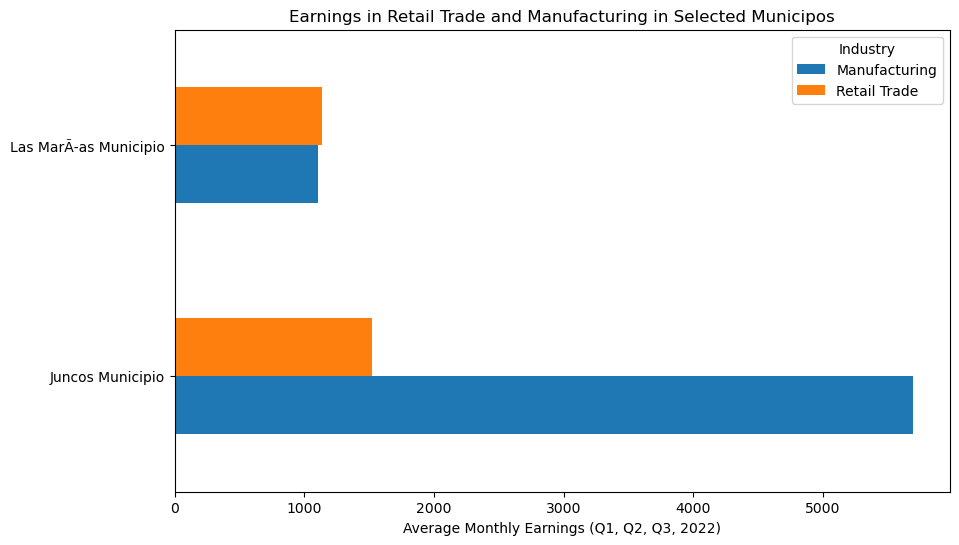

In [149]:
# plot the difference in LA Marias and Juncos

average_earnings = merged_counties.groupby(['county_name','industry'])['End-of-Quarter Employment: Average Monthly Earnings'].mean()
average_earnings.unstack().plot(kind='barh', figsize=(10,6))
plt.title('Earnings in Retail Trade and Manufacturing in Selected Municipos')
plt.xlabel('Average Monthly Earnings (Q1, Q2, Q3, 2022)')
plt.ylabel(None)
plt.xticks(rotation=0)
plt.legend(title='Industry')
plt.show()

In [150]:
# print the average earnings 
average_earnings

county_name            industry     
Juncos Municipio       Manufacturing    5690.333333
                       Retail Trade     1520.333333
Las MarÃ­as Municipio  Manufacturing    1107.000000
                       Retail Trade     1132.666667
Name: End-of-Quarter Employment: Average Monthly Earnings, dtype: float64

## Puerto Rican Community Survey

The Puerto Rico Community Survey provides data every year -- giving communities the current information they need to manage change. It is part of the Census Bureau's American Community Survey, customized for Puerto Rico. 

This section shows the change over time in the age distribution 

In [92]:
# set up empty lists to append API calls to
prcs_S1701_lst = []
S1701_df_years = []

# format the year with {}
prcs_S1701_api = 'https://api.census.gov/data/{}/acs/acs5/subject?get=group(S1701)&for=state:72&key=fe43695217081ac28642ce11f71882d406075d04'

# loop over the desired years 
for year in range(2015,2021+1):
    url_S1701 = prcs_S1701_api.format(year)
    prcs_S1701_r = requests.get(url_S1701)
    
    # save the columns and row data seperately
    data_for_prcs_year_columns = prcs_S1701_r.json()[0]
    data_for_prcs_year_estimates = prcs_S1701_r.json()[1:]
    
    # append to the established lists 
    prcs_S1701_lst.append(data_for_prcs_year_estimates[0])
    S1701_df_years.append(year)

# transform the row data into a dataframe
prcs_S1701_df = pd.DataFrame(prcs_S1701_lst)
# assign column names to the new dataframe
prcs_S1701_df.columns = data_for_prcs_year_columns
# save the year for plotting 
prcs_S1701_df['YEAR'] = S1701_df_years

Visualizing Poverty by Age over Time

In [93]:
# For whom poverty is detirmined...

#Age,under18,under5    #S1701_C01_003E
#Age,under18,under5-17 #S1701_C01_004E
#Age,18-64,18-34       #S1701_C01_007E       
#Age,18-64,35-64       #S1701_C01_008E
#Age,65+               #S1701_C01_010E
prcs_column_mapping = {'S1701_C01_003E':'Poverty_under5',
                       'S1701_C01_004E':'Poverty_5to17',
                       'S1701_C01_007E':'Poverty_18to34',
                       'S1701_C01_008E':'Poverty_35to64',
                       'S1701_C01_010E':'Poverty_65+',
                      'YEAR':'Year'}

# renaming columns and dropping those irrelevant to the graphic
prcs_S1701_df_poverty = prcs_S1701_df.rename(columns=prcs_column_mapping)
cols_to_drop_prcs = [col for col in prcs_S1701_df_poverty.columns if col not in prcs_column_mapping.values()]
prcs_S1701_df_poverty = prcs_S1701_df_poverty.drop(columns=cols_to_drop_prcs)
# setting the year as the index
prcs_S1701_df_poverty.set_index('Year',inplace=True)

# transforming data for graphing
cols_to_floats = ['Poverty_under5','Poverty_5to17','Poverty_18to34','Poverty_35to64','Poverty_65+']
for col in cols_to_floats:
    prcs_S1701_df_poverty[col] = prcs_S1701_df_poverty[col].astype(float)

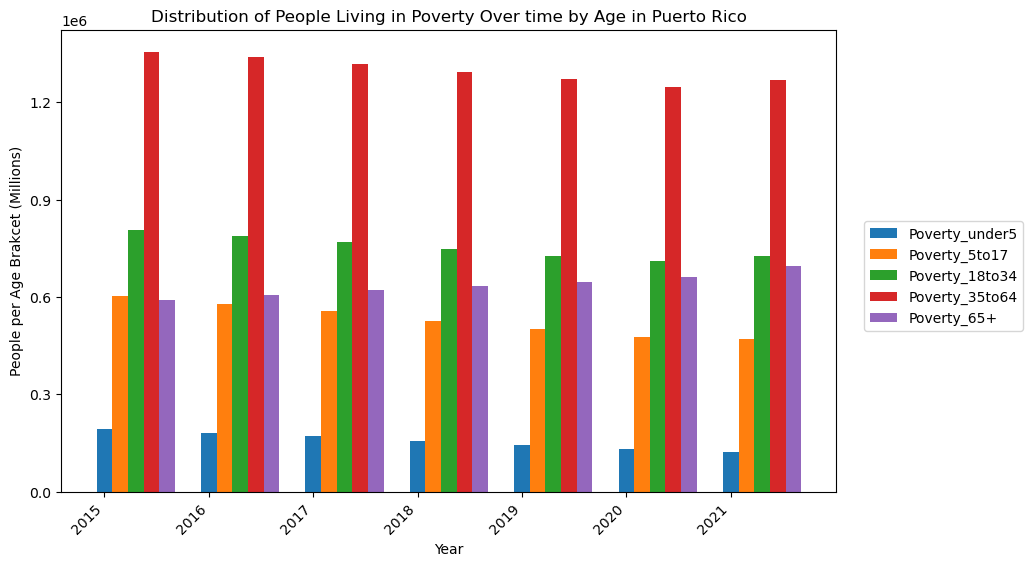

In [94]:
# plotting the age distribution of poverty over time 

age_brackets = prcs_S1701_df_poverty.columns
num_age_brackets = len(age_brackets)
num_years = len(prcs_S1701_df_poverty.index)
posistions = list(range(num_years))
bar_width = 0.15

plt.figure(figsize=(10,6))
for i, age_bracket in enumerate(age_brackets):
    plt.bar(
        [pos + i * bar_width for pos in posistions],
        prcs_S1701_df_poverty[age_bracket],
        width=bar_width,
        label=age_bracket
    )
plt.xlabel('Year')
plt.ylabel('People per Age Brakcet (Millions)')
plt.title('Distribution of People Living in Poverty Over time by Age in Puerto Rico')
plt.xticks(posistions, prcs_S1701_df_poverty.index, rotation=45,ha='right')
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

#plt.yticks(range(200000, 1500000, 100000))
#plt.xticks([pos + (num_age_brackets + 1) * bar_width / 2 for pos in positions], prcs_S1701_df_poverty.index)

plt.legend(bbox_to_anchor=(1.25,0.6), loc='upper right')
plt.show()

## Puerto Rican Community Resilience Estimates

The Community Resilience Estimates (CRE) for Puerto Rico provide an easily understood metric for a community’s capacity to withstand and recover from a disaster – such as a hurricane or hazardous event. It expands on the standard CRE, which focuses on the United States. 

This section produces a simple bar chart. 

Note that this data is only available through CSV by direct download at https://www.census.gov/data/experimental-data-products/cre-pr.html

In [61]:
# read the CSV file 
pr_cre_df = pd.read_csv('CRE19_PR.csv', encoding='latin-1')
# only the last row contains island-level data
pr_cre_summary = pr_cre_df.tail(1)
# rename the columns for readability 
pr_cre_variables = {'PRED0_E':'Zero Risk Factors',
                              'PRED12_E':'1-2 Risk Factors',
                              'PRED3_E':'3 or More Risk Factors'}
# drop the columns that are useful for analysis
pr_cre_summary = pr_cre_summary.rename(columns=pr_cre_variables)
cre_drops = [col for col in pr_cre_summary.columns if col not in pr_cre_variables.values()]

pr_cre_summary = pr_cre_summary.drop(columns=cre_drops)

# transpose the data for plotting
pr_cre_summary = pr_cre_summary.T.reset_index()

# rename the column names
pr_cre_summary = pr_cre_summary.rename(columns={'index':'Category',981:'Number of Persons'})

In [62]:
pr_cre_summary

Category  Number of Persons
0       Zero Risk Factors             468854
1        1-2 Risk Factors            1246295
2  3 or More Risk Factors            1464883

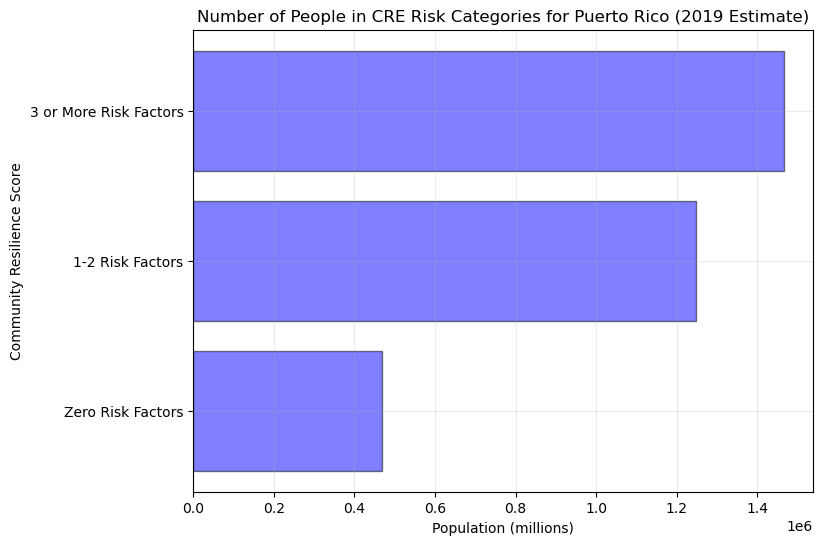

In [69]:
# plot the data 
plt.figure(figsize=(8,6))
plt.barh(pr_cre_summary['Category'],pr_cre_summary['Number of Persons'],color='blue',alpha=0.5, edgecolor='black')
plt.xlabel('Population (millions)')
plt.ylabel('Community Resilience Score')
plt.title('Number of People in CRE Risk Categories for Puerto Rico (2019 Estimate)')
plt.grid(True, alpha=0.25)
plt.show()

## Decennial Census

Although the U.S. Census Bureau carries out hundreds of surveys every year, its most well-known duty is still to conduct the decennial census.  
  
The Decennial Census API is only availbel for Puerto Rico for 2000, 2010, and 2020. 

This simple chart so the population decline of Puerto Rico over time. 

In [11]:
# population decline over time
# create an empty list to append each API call to for the given years
pr_pop_decenial_lst = []

# set the API calls for each Decennial Census
pr_pop_url_2020 = 'https://api.census.gov/data/2020/dec/dhc?get=NAME,P1_001N&for=state:72&key=fe43695217081ac28642ce11f71882d406075d04'
pr_pop_url_2010 = 'https://api.census.gov/data/2010/dec/sf1?get=NAME,P001001&for=state:72&key=fe43695217081ac28642ce11f71882d406075d04'
pr_pop_url_2000 = 'https://api.census.gov/data/2000/dec/sf1?get=NAME,P001001&for=state:72&key=fe43695217081ac28642ce11f71882d406075d04'

# append the cycle to the empty list
pr_pop_2020_r = requests.get(pr_pop_url_2020)
pr_pop_2020_estimates = pr_pop_2020_r.json()[1]
pr_pop_decenial_lst.append(pr_pop_2020_estimates)

pr_pop_2010_r = requests.get(pr_pop_url_2010)
pr_pop_2010_estimates = pr_pop_2010_r.json()[1]
pr_pop_decenial_lst.append(pr_pop_2010_estimates)

pr_pop_2000_r = requests.get(pr_pop_url_2000)
pr_pop_2000_estimates = pr_pop_2000_r.json()[1]
pr_pop_decenial_lst.append(pr_pop_2000_estimates)

# transform the list of lists into a dataframe
pr_pop_decenial = pd.DataFrame(pr_pop_decenial_lst)

# set the columns
pr_pop_decenial.columns = ['State', 'Population', 'FIPS']

# add a year to distinguish each row
pr_pop_decenial['Year'] = [2020,2010,2000]
pr_pop_decenial['Year'] = pr_pop_decenial['Year'].astype(int)
pr_pop_decenial['Population'] = pr_pop_decenial['Population'].astype(float)

In [86]:
# preveiw the decline
pr_pop_decenial

State  Population FIPS  Year
0  Puerto Rico   3285874.0   72  2020
1  Puerto Rico   3725789.0   72  2010
2  Puerto Rico   3808610.0   72  2000

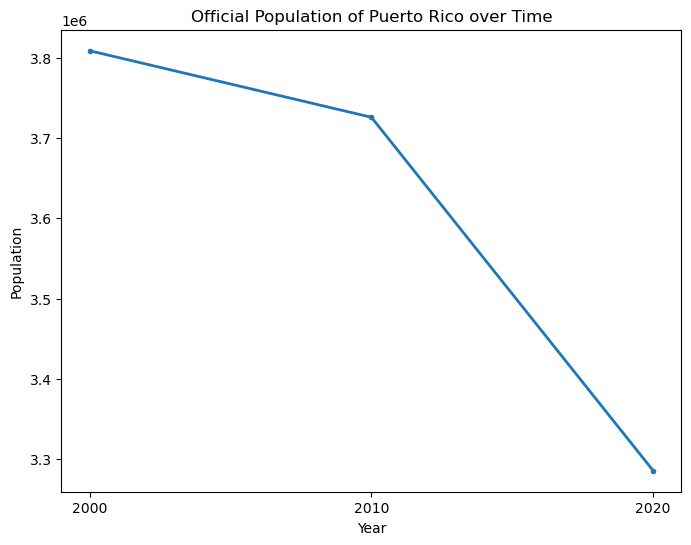

In [87]:
# plot the simple data frame as a line graph
plt.figure(figsize=(8,6))
plt.plot(pr_pop_decenial['Year'], pr_pop_decenial['Population'], label='Population', linewidth=2, marker='.',linestyle='-')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Official Population of Puerto Rico over Time')
plt.xticks([2000,2010,2020])
plt.show()